### for kaggle notebook

In [5]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 95%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [2]:
# !pip install lightgbm
# !pip install catboost
# !pip install xgboost
# !pip install tabpfn
# !pip install seaborn
# !pip install optuna

In [3]:
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold

import lightgbm
import optuna

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
import warnings
warnings.filterwarnings("ignore")

In [4]:
#from tabpfn import TabPFNClassifier
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PowerTransformer

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random, os
import math


In [6]:
# https://github.com/trent-b/iterative-stratification
# I copied it from the above github.
import numpy as np

from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples, check_array
from sklearn.utils.multiclass import type_of_target

from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits, \
    BaseShuffleSplit, _validate_shuffle_split


def IterativeStratification(labels, r, random_state):
    """This function implements the Iterative Stratification algorithm described
    in the following paper:
    Sechidis K., Tsoumakas G., Vlahavas I. (2011) On the Stratification of
    Multi-Label Data. In: Gunopulos D., Hofmann T., Malerba D., Vazirgiannis M.
    (eds) Machine Learning and Knowledge Discovery in Databases. ECML PKDD
    2011. Lecture Notes in Computer Science, vol 6913. Springer, Berlin,
    Heidelberg.
    """

    n_samples = labels.shape[0]
    test_folds = np.zeros(n_samples, dtype=int)

    # Calculate the desired number of examples at each subset
    c_folds = r * n_samples

    # Calculate the desired number of examples of each label at each subset
    c_folds_labels = np.outer(r, labels.sum(axis=0))

    labels_not_processed_mask = np.ones(n_samples, dtype=bool)

    while np.any(labels_not_processed_mask):
        # Find the label with the fewest (but at least one) remaining examples,
        # breaking ties randomly
        num_labels = labels[labels_not_processed_mask].sum(axis=0)

        # Handle case where only all-zero labels are left by distributing
        # across all folds as evenly as possible (not in original algorithm but
        # mentioned in the text). (By handling this case separately, some
        # code redundancy is introduced; however, this approach allows for
        # decreased execution time when there are a relatively large number
        # of all-zero labels.)
        if num_labels.sum() == 0:
            sample_idxs = np.where(labels_not_processed_mask)[0]

            for sample_idx in sample_idxs:
                fold_idx = np.where(c_folds == c_folds.max())[0]

                if fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(fold_idx.shape[0])]

                test_folds[sample_idx] = fold_idx
                c_folds[fold_idx] -= 1

            break

        label_idx = np.where(num_labels == num_labels[np.nonzero(num_labels)].min())[0]
        if label_idx.shape[0] > 1:
            label_idx = label_idx[random_state.choice(label_idx.shape[0])]

        sample_idxs = np.where(np.logical_and(labels[:, label_idx].flatten(), labels_not_processed_mask))[0]

        for sample_idx in sample_idxs:
            # Find the subset(s) with the largest number of desired examples
            # for this label, breaking ties by considering the largest number
            # of desired examples, breaking further ties randomly
            label_folds = c_folds_labels[:, label_idx]
            fold_idx = np.where(label_folds == label_folds.max())[0]

            if fold_idx.shape[0] > 1:
                temp_fold_idx = np.where(c_folds[fold_idx] ==
                                         c_folds[fold_idx].max())[0]
                fold_idx = fold_idx[temp_fold_idx]

                if temp_fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(temp_fold_idx.shape[0])]

            test_folds[sample_idx] = fold_idx
            labels_not_processed_mask[sample_idx] = False

            # Update desired number of examples
            c_folds_labels[fold_idx, labels[sample_idx]] -= 1
            c_folds[fold_idx] -= 1

    return test_folds


class MultilabelStratifiedKFold(_BaseKFold):
    """Multilabel stratified K-Folds cross-validator
    Provides train/test indices to split multilabel data into train/test sets.
    This cross-validation object is a variation of KFold that returns
    stratified folds for multilabel data. The folds are made by preserving
    the percentage of samples for each label.
    Parameters
    ----------
    n_splits : int, default=3
        Number of folds. Must be at least 2.
    shuffle : boolean, optional
        Whether to shuffle each stratification of the data before splitting
        into batches.
    random_state : int, RandomState instance or None, optional, default=None
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`. Unlike StratifiedKFold that only uses random_state
        when ``shuffle`` == True, this multilabel implementation
        always uses the random_state since the iterative stratification
        algorithm breaks ties randomly.
    Examples
    --------
    >>> from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
    >>> import numpy as np
    >>> X = np.array([[1,2], [3,4], [1,2], [3,4], [1,2], [3,4], [1,2], [3,4]])
    >>> y = np.array([[0,0], [0,0], [0,1], [0,1], [1,1], [1,1], [1,0], [1,0]])
    >>> mskf = MultilabelStratifiedKFold(n_splits=2, random_state=0)
    >>> mskf.get_n_splits(X, y)
    2
    >>> print(mskf)  # doctest: +NORMALIZE_WHITESPACE
    MultilabelStratifiedKFold(n_splits=2, random_state=0, shuffle=False)
    >>> for train_index, test_index in mskf.split(X, y):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0 3 4 6] TEST: [1 2 5 7]
    TRAIN: [1 2 5 7] TEST: [0 3 4 6]
    Notes
    -----
    Train and test sizes may be slightly different in each fold.
    See also
    --------
    RepeatedMultilabelStratifiedKFold: Repeats Multilabel Stratified K-Fold
    n times.
    """

    def __init__(self, n_splits=3, *, shuffle=False, random_state=None):
        super(MultilabelStratifiedKFold, self).__init__(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    def _make_test_folds(self, X, y):
        y = np.asarray(y, dtype=bool)
        type_of_target_y = type_of_target(y)

        if type_of_target_y != 'multilabel-indicator':
            raise ValueError(
                'Supported target type is: multilabel-indicator. Got {!r} instead.'.format(type_of_target_y))

        num_samples = y.shape[0]

        rng = check_random_state(self.random_state)
        indices = np.arange(num_samples)

        if self.shuffle:
            rng.shuffle(indices)
            y = y[indices]

        r = np.asarray([1 / self.n_splits] * self.n_splits)

        test_folds = IterativeStratification(labels=y, r=r, random_state=rng)

        return test_folds[np.argsort(indices)]

    def _iter_test_masks(self, X=None, y=None, groups=None):
        test_folds = self._make_test_folds(X, y)
        for i in range(self.n_splits):
            yield test_folds == i

    def split(self, X, y, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            Note that providing ``y`` is sufficient to generate the splits and
            hence ``np.zeros(n_samples)`` may be used as a placeholder for
            ``X`` instead of actual training data.
        y : array-like, shape (n_samples, n_labels)
            The target variable for supervised learning problems.
            Multilabel stratification is done based on the y labels.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        Notes
        -----
        Randomized CV splitters may return different results for each call of
        split. You can make the results identical by setting ``random_state``
        to an integer.
        """
        y = check_array(y, ensure_2d=False, dtype=None)
        return super(MultilabelStratifiedKFold, self).split(X, y, groups)


class RepeatedMultilabelStratifiedKFold(_RepeatedSplits):
    """Repeated Multilabel Stratified K-Fold cross validator.
    Repeats Mulilabel Stratified K-Fold n times with different randomization
    in each repetition.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    n_repeats : int, default=10
        Number of times cross-validator needs to be repeated.
    random_state : None, int or RandomState, default=None
        Random state to be used to generate random state for each
        repetition as well as randomly breaking ties within the iterative
        stratification algorithm.
    Examples
    --------
    >>> from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold
    >>> import numpy as np
    >>> X = np.array([[1,2], [3,4], [1,2], [3,4], [1,2], [3,4], [1,2], [3,4]])
    >>> y = np.array([[0,0], [0,0], [0,1], [0,1], [1,1], [1,1], [1,0], [1,0]])
    >>> rmskf = RepeatedMultilabelStratifiedKFold(n_splits=2, n_repeats=2,
    ...     random_state=0)
    >>> for train_index, test_index in rmskf.split(X, y):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    ...
    TRAIN: [0 3 4 6] TEST: [1 2 5 7]
    TRAIN: [1 2 5 7] TEST: [0 3 4 6]
    TRAIN: [0 1 4 5] TEST: [2 3 6 7]
    TRAIN: [2 3 6 7] TEST: [0 1 4 5]
    See also
    --------
    RepeatedStratifiedKFold: Repeats (Non-multilabel) Stratified K-Fold
    n times.
    """
    def __init__(self, n_splits=5, *, n_repeats=10, random_state=None):
        super(RepeatedMultilabelStratifiedKFold, self).__init__(
            MultilabelStratifiedKFold, n_repeats=n_repeats, random_state=random_state,
            n_splits=n_splits)


class MultilabelStratifiedShuffleSplit(BaseShuffleSplit):
    """Multilabel Stratified ShuffleSplit cross-validator
    Provides train/test indices to split data into train/test sets.
    This cross-validation object is a merge of MultilabelStratifiedKFold and
    ShuffleSplit, which returns stratified randomized folds for multilabel
    data. The folds are made by preserving the percentage of each label.
    Note: like the ShuffleSplit strategy, multilabel stratified random splits
    do not guarantee that all folds will be different, although this is
    still very likely for sizeable datasets.
    Parameters
    ----------
    n_splits : int, default 10
        Number of re-shuffling & splitting iterations.
    test_size : float, int, None, optional
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. By default, the value is set to 0.1.
        The default will change in version 0.21. It will remain 0.1 only
        if ``train_size`` is unspecified, otherwise it will complement
        the specified ``train_size``.
    train_size : float, int, or None, default is None
        If float, should be between 0.0 and 1.0 and represent the
        proportion of the dataset to include in the train split. If
        int, represents the absolute number of train samples. If None,
        the value is automatically set to the complement of the test size.
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`. Unlike StratifiedShuffleSplit that only uses
        random_state when ``shuffle`` == True, this multilabel implementation
        always uses the random_state since the iterative stratification
        algorithm breaks ties randomly.
    Examples
    --------
    >>> from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
    >>> import numpy as np
    >>> X = np.array([[1,2], [3,4], [1,2], [3,4], [1,2], [3,4], [1,2], [3,4]])
    >>> y = np.array([[0,0], [0,0], [0,1], [0,1], [1,1], [1,1], [1,0], [1,0]])
    >>> msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.5,
    ...    random_state=0)
    >>> msss.get_n_splits(X, y)
    3
    >>> print(mss)       # doctest: +ELLIPSIS
    MultilabelStratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.5,
                                     train_size=None)
    >>> for train_index, test_index in msss.split(X, y):
    ...    print("TRAIN:", train_index, "TEST:", test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [1 2 5 7] TEST: [0 3 4 6]
    TRAIN: [2 3 6 7] TEST: [0 1 4 5]
    TRAIN: [1 2 5 6] TEST: [0 3 4 7]
    Notes
    -----
    Train and test sizes may be slightly different from desired due to the
    preference of stratification over perfectly sized folds.
    """

    def __init__(self, n_splits=10, *, test_size="default", train_size=None,
                 random_state=None):
        super(MultilabelStratifiedShuffleSplit, self).__init__(
            n_splits=n_splits, test_size=test_size, train_size=train_size, random_state=random_state)

    def _iter_indices(self, X, y, groups=None):
        n_samples = _num_samples(X)
        y = check_array(y, ensure_2d=False, dtype=None)
        y = np.asarray(y, dtype=bool)
        type_of_target_y = type_of_target(y)

        if type_of_target_y != 'multilabel-indicator':
            raise ValueError(
                'Supported target type is: multilabel-indicator. Got {!r} instead.'.format(
                    type_of_target_y))

        n_train, n_test = _validate_shuffle_split(n_samples, self.test_size,
                                                  self.train_size)

        n_samples = y.shape[0]
        rng = check_random_state(self.random_state)
        y_orig = y.copy()

        r = np.array([n_train, n_test]) / (n_train + n_test)

        for _ in range(self.n_splits):
            indices = np.arange(n_samples)
            rng.shuffle(indices)
            y = y_orig[indices]

            test_folds = IterativeStratification(labels=y, r=r, random_state=rng)

            test_idx = test_folds[np.argsort(indices)] == 1
            test = np.where(test_idx)[0]
            train = np.where(~test_idx)[0]

            yield train, test

    def split(self, X, y, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            Note that providing ``y`` is sufficient to generate the splits and
            hence ``np.zeros(n_samples)`` may be used as a placeholder for
            ``X`` instead of actual training data.
        y : array-like, shape (n_samples, n_labels)
            The target variable for supervised learning problems.
            Multilabel stratification is done based on the y labels.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        Notes
        -----
        Randomized CV splitters may return different results for each call of
        split. You can make the results identical by setting ``random_state``
        to an integer.
        """
        y = check_array(y, ensure_2d=False, dtype=None)
        return super(MultilabelStratifiedShuffleSplit, self).split(X, y, groups)

# Flags

In [74]:
# SMOTEをTrueにすると、5FOLDの結果にリークが発生しているように見えるのでCVがあてにならなくなりそう
use_SMOTE = False
check_CV = True
del_BC_CL = False
do_opt = False
use_new_pred = True

use_GPU = False

positive_weight  = 2.0
positive_weight2 = 2.0

# 学習ループを行う・行わない（Pytorch部分）
torch_train = False

# use fold best
use_best_fold = False

seed = 57

In [75]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    use_GPU = True
use_GPU, device

(False, 'cpu')

# Functions

In [76]:
def calc_new_pred(pred):
    class_0_est_instances = pred[:,0].sum()
    others_est_instances = pred[:,1:].sum()
    
    if class_0_est_instances == 0 or others_est_instances == 0 :
        return pred
    # we reweight the probs, since the loss is also balanced like this
    # our models out of the box optimize CE
    # with these changes they optimize balanced CE
    new_p = pred * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(pred.shape[1])]])
    return new_p / np.sum(new_p,axis=1,keepdims=1)

In [77]:
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

In [78]:
def competition_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    return (log_loss_0 + log_loss_1)/2

def __balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

def lgb_metric(y_true, y_pred):
    return 'balanced_log_loss', __balanced_log_loss(y_true, y_pred), False

# Read DATAS

In [79]:
df = pd.read_csv("../input/icr-identify-age-related-conditions/train.csv", index_col=[0])
greeks_df = pd.read_csv("../input/icr-identify-age-related-conditions/greeks.csv", index_col=[0])

# マジック（Epsilonを入れる）　🌟
times = greeks_df.Epsilon.copy()
times[greeks_df.Epsilon != 'Unknown'] = greeks_df.Epsilon[greeks_df.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks_df.Epsilon == 'Unknown'] = greeks_df.Epsilon[greeks_df.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal()).median()
greeks_df['times'] = times
df = df.merge(greeks_df['times'], left_index = True, right_index = True, how='left')
new_order = df.columns.to_list()
new_order[-2], new_order[-1] = new_order[-1], new_order[-2]
df_train = df.reindex(columns=new_order)
del df

In [80]:
# # 2020-01-01より前を除外
# sel = greeks_df.Epsilon != "Unknown"
# greeks_df.loc[~sel, 'Epsilon'] = dt.datetime(1900,1,1)
# greeks_df.loc[sel, 'Epsilon'] = pd.to_datetime(greeks_df.loc[sel, 'Epsilon'],  format='%m/%d/%Y')
# df_train = df_train[greeks_df.Epsilon > dt.datetime(2020,1,1)]
# greeks_df = greeks_df[greeks_df.Epsilon > dt.datetime(2020,1,1)]
# df_train

In [81]:
df_test = pd.read_csv("../input/icr-identify-age-related-conditions/test.csv", index_col=[0])
df_test['times'] = times.max()+1
df_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,times
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0


In [82]:
df_train['EJ'] = df_train['EJ'].map({'A': 0.0, 'B': 1.0}, na_action=None)
df_test['EJ'] = df_test['EJ'].map({'A': 0.0, 'B': 1.0}, na_action=None)

In [83]:
greeks_df['Class'] = greeks_df['Alpha'].map({'A': 0, 'B': 1, 'D': 2, 'G': 3 }, na_action=None)
greeks_df

,Alpha,Beta,Gamma,Delta,Epsilon,times,Class
Id,,,,,,,
000ff2bfdfe9,B,C,G,D,3/19/2019,737137.0,1
007255e47698,A,C,M,B,Unknown,737269.0,0
013f2bd269f5,A,C,M,B,Unknown,737269.0,0
043ac50845d5,A,C,M,B,Unknown,737269.0,0
044fb8a146ec,D,B,F,B,3/25/2020,737509.0,2
...,...,...,...,...,...,...,...
fd3dafe738fd,A,B,M,B,9/13/2020,737681.0,0
fd895603f071,A,B,M,B,9/8/2020,737676.0,0
fd8ef6377f76,A,C,M,B,7/24/2019,737264.0,0


## nanをmedianに変更

In [84]:
#　https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/417250
# df_train['EL'] = df_train['EL'].fillna(df_train['EL'].mode()[0]) <-- 要検討

col_mean = df_train.median(axis=0)
# col_mean = df_train.mode().iloc[0]
for i, colname in enumerate(df_train.columns):
    df_train[colname].fillna(col_mean[i], inplace=True)
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,times,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,737137.0,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,737269.0,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,737269.0,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,737269.0,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,737509.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,737681.0,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,737676.0,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,737264.0,0


In [85]:
for i, colname in enumerate(df_test.columns):
    df_test[colname].fillna(col_mean[i], inplace=True)
df_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,times
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,737698.0


### 列 BC と CL を削除
自分のコードではCVが低下したので一旦コメントアウト

https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/414638

In [86]:
if del_BC_CL:
    df_train = df_train.drop(['BC','CL'], axis=1)
    df_test = df_test.drop(['BC','CL'], axis=1)

### smote
今回は効果なさそうなので使わない。use_SMOTEもoff固定！！ **使うと不具合出るかも**

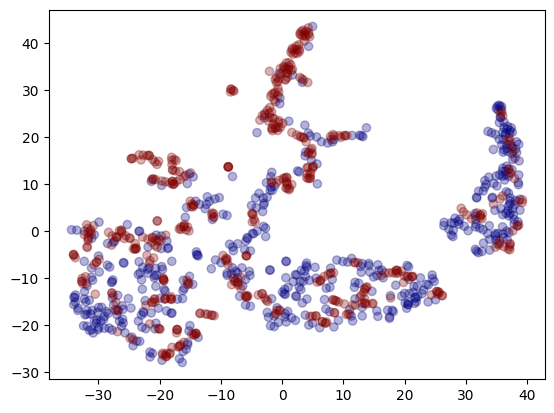

In [87]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

X = df_train[df_train.columns[:-1]]
y = df_train.Class
sm = SMOTETomek(random_state=57)
X_res, y_res = sm.fit_resample(X, y)

from sklearn.manifold import TSNE
pca = TSNE(n_components=2, random_state=0)
X_reduced_tsne = pca.fit_transform(X_res)  # wineデータをPCAで次元圧縮
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1],
            c=y_res, cmap='jet', alpha=0.3)
plt.show()

if use_SMOTE:
    X_res['Class'] = y_res
    df_train = X_res

In [88]:
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,times,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,737137.0,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,737269.0,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,737269.0,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,737269.0,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,737509.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,737681.0,0
fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,737676.0,0
fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,737264.0,0


### yeo-johnson変換

In [89]:
# cols = df_train.columns[:-2]
# pt = PowerTransformer(method='yeo-johnson')
# pt.fit(df_train[cols].values)
# df_train[cols] = pt.transform(df_train[cols].values)
# df_test[cols] = pt.transform(df_test[cols].values)
# 
# df_train

## スケールを変更

In [90]:
df_train_noscale = df_train.copy()

scaler = RobustScaler().set_output(transform="pandas")
df_train.loc[:, df_train.columns[:-2]] = scaler.fit_transform(df_train[df_train.columns[:-2]])
df_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,times,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,-0.472222,-0.005214,0.000000,0.069272,0.000000,-1.880769,0.000000,-0.134115,1.123175,-0.463451,...,0.598571,-0.333333,-0.642283,0.000000,-0.359338,-0.716263,0.641741,-0.009952,737137.0,1
007255e47698,-0.680556,-0.989494,0.000000,0.611687,0.000000,-0.607692,0.000000,0.631510,0.000000,0.265382,...,-0.624571,0.681159,-0.819132,0.000000,1.240601,-0.124567,-0.197595,0.990234,737269.0,0
013f2bd269f5,0.375000,-0.224190,0.000000,0.440180,0.000000,0.738462,0.000000,0.488281,0.000000,0.073301,...,-0.153143,2.028986,1.581994,0.290982,0.359598,-0.218622,-0.129459,-0.006447,737269.0,0
043ac50845d5,-0.333333,0.323123,1.226427,2.105694,0.000000,-0.584615,0.000000,0.122396,0.000000,-0.440533,...,-0.624571,0.072464,-0.020900,0.178349,-0.353767,0.789556,1.101632,-0.008328,737269.0,0
044fb8a146ec,0.083333,0.283109,0.000000,-0.239281,0.000000,-0.473077,2.594595,-1.459635,26.204380,0.388671,...,46.670286,-0.275362,-0.204180,1.336815,0.042256,1.248820,-0.105640,-0.011038,737509.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,-0.666667,0.004501,1.351236,-0.410097,4.882164,-0.665385,4.594595,-0.395833,0.408759,-0.446912,...,0.128000,-0.391304,-0.847267,2.628881,0.015869,-0.504561,0.627426,0.990234,737681.0,0
fd895603f071,0.263889,1.081978,0.000000,0.968303,7.834536,0.411538,0.027027,0.446615,0.661496,0.348963,...,0.109714,0.376812,1.479904,7.718779,-0.292729,-0.081158,1.865560,-0.008808,737676.0,0
fd8ef6377f76,0.236111,-0.305510,1.574611,1.295989,1.866864,1.319231,0.000000,1.022135,0.000000,0.473846,...,-0.624571,-0.391304,0.102894,1.023740,-0.083984,-0.375590,1.748697,0.990234,737264.0,0


In [91]:
df_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000
mean,0.398141,0.176360,1.171166,0.686109,1.989554,0.223008,3.083622,0.021721,1.771618,0.187443,...,0.395963,2.367394,0.364503,0.168810,1.074996,0.421349,0.074458,0.213190,0.374303,0.175041
std,1.522442,1.062852,4.479386,2.595063,10.518877,1.107824,36.996129,0.898906,16.920572,1.606932,...,1.894317,49.440342,2.788738,0.863479,2.622407,1.191926,0.833899,0.807352,0.472412,0.380310
min,-0.888889,-1.352741,0.000000,-0.645920,0.000000,-1.880769,0.000000,-1.459635,0.000000,-1.757455,...,-0.470789,-0.624571,-0.391304,-1.267685,0.000000,-0.481947,-1.790186,-0.892929,-0.015407,0.000000
25%,-0.333333,-0.426455,0.000000,-0.307515,0.000000,-0.392308,0.000000,-0.481771,0.000000,-0.447966,...,-0.470789,-0.624571,-0.391304,-0.409164,0.000000,-0.310363,-0.471217,-0.400630,-0.009766,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.573545,1.000000,0.692485,0.000000,0.607692,1.000000,0.518229,1.000000,0.552034,...,0.529211,0.375429,0.608696,0.590836,1.000000,0.689637,0.528783,0.599370,0.990234,0.000000
max,18.875000,11.813503,63.944004,22.701706,170.804946,14.430769,913.351351,5.890625,379.728102,25.562747,...,22.246434,1224.725143,66.579710,10.111736,25.913517,8.373109,4.277760,3.343430,0.990234,1.000000


In [92]:
df_test_noscale = df_test.copy()

df_test.loc[:,df_test.columns[:-1]] = scaler.transform(df_test[df_test.columns[:-1]])
df_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,times
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.499355,-1.114286,-0.536232,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015459,737698.0
010ebe33f668,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.499355,-1.114286,-0.536232,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015459,737698.0
02fa521e1838,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.499355,-1.114286,-0.536232,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015459,737698.0
040e15f562a2,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.499355,-1.114286,-0.536232,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015459,737698.0
046e85c7cc7f,-1.152778,-1.441727,-2.985352,-0.764177,-8.138688,-2.184615,-2.27027,-2.161458,-0.319343,-2.658231,...,-0.499355,-1.114286,-0.536232,-1.622186,-1.320667,-0.48275,-2.587606,-0.912912,-0.015459,737698.0


In [93]:
df_train['times'] = df_train.times.astype(int)
df_test['times'] = df_test.times.astype(int)

## select columns

In [94]:
# cols_train = ['AH', 'CC', 'GI', 'BQ', 'GH', 'DE', 'BR', 'EP', 'EL', 'CL', 'CD ', 'AM', 'EU', 'FI', 'EE', 'CU', 'DU', 'GL', 'DL', 'DV',"Class"]
# cols_test = ['AH', 'CC', 'GI', 'BQ', 'GH', 'DE', 'BR', 'EP', 'EL', 'CL', 'CD ', 'AM', 'EU', 'FI', 'EE', 'CU', 'DU', 'GL', 'DL', 'DV']
# df_train = df_train[cols_train]
# df_test = df_test[cols_test]
# df_test

# PyTorch

In [95]:
class cfg :
    TRAIN_BATCHSIZE = 64
    VALID_BATCHSIZE = 200
    learning_rate = 0.0005
#     learning_rate = 0.001
    num_epochs = 3000
    seed = seed
    
cfg.__dict__.items()

dict_items([('__module__', '__main__'), ('TRAIN_BATCHSIZE', 64), ('VALID_BATCHSIZE', 200), ('learning_rate', 0.0005), ('num_epochs', 3000), ('seed', 57), ('__dict__', <attribute '__dict__' of 'cfg' objects>), ('__weakref__', <attribute '__weakref__' of 'cfg' objects>), ('__doc__', None)])

In [96]:
# np.random.normal(loc=0, scale=0.1, size=56).astype(np.float32) > 0

### dataset/dataloader

In [97]:
class MyDataset(Dataset):
    def __init__(self, df, is_train=False):
        super().__init__()
        self.df = df
        self.is_train = is_train
        
        self.noise_mean = 0 
        self.noise_std = 0.01
        self.th = 0.50
        self.mask = np.array([1 if e != "EJ" else 0 for e in df_train.columns])[:-2].astype(np.float32)
        
        X = df[df.columns[:-2]]
        y = df.Class
        self.X = X
        self.y = y
#         sm = SMOTETomek(random_state=57)
#         X_res, y_res = sm.fit_resample(X, y)
#         self.X = X_res
#         self.y = y_res
        
    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index
    ) :
#         print(index, self.df.iloc[index])
      
#         data = torch.Tensor(self.df.iloc[index, :-2].to_numpy())
#         label = self.df.Class[index]
        data = torch.Tensor(self.X.iloc[index, : ].to_numpy())
        label = y_res[index]
    
        # データ拡張（0, 0.05)の正規分布ノイズを付加
        if self.is_train and random.random() < self.th:
#             m2 = np.random.normal(loc=self.noise_mean, scale=self.noise_std, size=self.mask.shape).astype(np.float32) > 0
            data += self.mask * np.random.normal(loc=self.noise_mean, scale=self.noise_std, size=self.mask.shape).astype(np.float32)        
        
        return data, label

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.df)
    
dat = MyDataset(df_train, is_train=True)
dat[0]

(tensor([-0.4722, -0.0052,  0.0000,  0.0693,  0.0000, -1.8808,  0.0000, -0.1341,
          1.1232, -0.4635,  0.3333, -0.2009,  0.9814,  0.3569,  0.0000,  0.0865,
         -0.4587, -1.6082, -0.5025, -0.4000,  0.0000, -2.4523, -1.9588, -0.0841,
          0.0060,  0.8481, -0.0374,  0.0000, -0.5625, -0.6463, -0.3687,  0.4565,
          4.8193,  0.0000,  0.0799, -0.1885, -0.2781, -0.0763,  3.6883,  0.0000,
         -0.5421,  0.0000, -0.4203, -0.7452,  1.8316,  0.3070, -2.1252,  0.7041,
          0.5986, -0.3333, -0.6423,  0.0000, -0.3593, -0.7163,  0.6417, -0.0100]),
 1)

### model

In [98]:
"""
margin: 通常、2クラス分類ではmarginの値は0.2から0.5の範囲で設定されます。
    この範囲内での値の選択は、同じクラスの特徴ベクトルを近くに、異なるクラスの
    特徴ベクトルを遠くに分離する効果を持ちます。具体的な値は実験によって調整する
    必要がありますが、一般的には0.3や0.4が試されることが多いです。
scale: 2クラス分類の場合、scaleの値は一般的に10から30程度が使用されます。
    値が大きいほど、クラス分類の確信度が高まりますが、適切な値はデータセットやタスクに
    依存します。一般的な出発点としては、10や20を試してみることができます。
"""
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, train, label=False):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        if train:
            one_hot = torch.zeros(cosine.size())
            if device == "cpu":
                one_hot.scatter_(1, label.view(-1, 1).long(), 1)
            else:
                one_hot = torch.zeros(cosine.size(), device='cuda')
                one_hot.scatter_(1, label.cuda().view(-1, 1).long(), 1)
            output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        else:
            output = cosine
        output *= self.s

        return output

In [99]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, last_hidden_dim=64):
        super(MyModel, self).__init__()

#         self.bn1 = nn.BatchNorm1d(input_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(last_hidden_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, last_hidden_dim)
#         self.arcface = ArcMarginProduct(last_hidden_dim, output_dim, s = 10, m = 0.1)
        self.arcface = ArcMarginProduct(last_hidden_dim, output_dim, s = 15, m = 0.1)
        
        self.dropout01 = nn.Dropout(0.05)
        self.dropout05 = nn.Dropout(0.25)

    def forward(self, x, labels):
#         x = self.bn1(x)
        x = self.dropout01(x)
        x = F.mish(self.bn2(self.fc1(x)))
        x = self.dropout05(x)
        x = F.mish(self.bn3(self.fc2(x)))
        if self.training:
            logits = self.arcface(x, self.training, labels)
        else:
            logits = self.arcface(x, self.training)
        return logits, x

In [100]:
# def balanced_log_loss(y_true, y_pred):
#     y_pred = y_pred.astype('float64')
#     y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
#     nc = np.bincount(y_true)
#     w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
#     balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
#     return balanced_log_loss_score

from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred):
    y_pred = y_pred.astype('float64')    
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

In [101]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
# criterion = F.cross_entropy

In [102]:
balance = torch.Tensor([len(df_train)/sum(df_train.Class == i) for i in range(len(df_train.Class.unique()))])
balance /= sum(balance)
balance

tensor([0.1750, 0.8250])

### train

In [103]:
from tqdm import tqdm

In [104]:
def train(fold, train_dataloader,valid_dataloader, input_dim, output_dim, total_epoch = None):
    best_score = 10**18
    best_epoch = -1
    model = MyModel(input_dim, output_dim).to(device)

    optimizer = optim.Adamax(model.parameters(), lr=cfg.learning_rate)
#     criterion = nn.CrossEntropyLoss().to(device)
    criterion = nn.CrossEntropyLoss(weight=balance).to(device)
    
    if total_epoch is None:
        total_epoch = cfg.num_epochs
    
    with tqdm(total=total_epoch) as pbar:
        for epoch in range(total_epoch):
            y_true = []
            y_pred = []    

            model.train()  # モデルを訓練モードに設定
            total_loss = 0.0
            for batch in train_dataloader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()  # 勾配の初期化
                # フォワード処理
                outputs, _ = model(inputs, labels)      
                # 損失の計算
                loss = criterion(outputs, labels)
                # バックワード処理
                loss.backward()
                # パラメータの更新
                optimizer.step()
                total_loss += loss.detach().item()
            avg_train_loss = total_loss / len(train_dataloader)

            model.eval()  # モデルをvalidモードに設定
            total_loss = 0.0


            for batch in valid_dataloader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                with torch.no_grad():
                    outputs, _ = model(inputs, labels)     
                loss = criterion(outputs, labels)
                total_loss += loss.detach().item()
                y_true += (labels.detach().tolist())
                y_pred += (1 - F.softmax(outputs, dim=1)[:, 0]).detach().tolist()
            avg_valid_loss = total_loss / len(valid_dataloader)

            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            score = balanced_log_loss(y_true, y_pred)
#             score = avg_valid_loss

            pbar.set_postfix(train=avg_train_loss, valid=avg_valid_loss, score=score, best_score=best_score, best_epoch=best_epoch)
            pbar.update(1)
            if epoch > 100 and best_score > score:
                last_file = f"model_weight_fold{fold}.pth"
                best_score = min(best_score, score)
                best_epoch = epoch+1
                torch.save(model.state_dict(), f"model_weight_fold{fold}.pth")

    torch.save(model.state_dict(), f"model_weight_last_fold{fold}.pth")

    return best_score


In [105]:
seed_everything(cfg.seed)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

num = 0
score = 0
is_train = True

# timesは入れない！！！！
input_dim = len(df_train.columns)-2
output_dim = len(df_train.Class.unique())

if torch_train:
    for num, (train_idx, valid_idx) in enumerate(kf.split(df_train, greeks_df.Class)):
#         if num != 4 : continue
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        train_dataset = MyDataset(train_df, is_train=is_train)
        valid_dataset = MyDataset(valid_df)
        train_dataloader = DataLoader(train_dataset, batch_size=cfg.TRAIN_BATCHSIZE, shuffle=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.VALID_BATCHSIZE, shuffle=False)

        print(f"Fold{num}")
        score += train(num, train_dataloader, valid_dataloader, input_dim, output_dim)

        num+=1

    print(score/5)

Fold0
100%|██████████| 1000/1000 [04:09<00:00,  4.00it/s, best_epoch=951, best_score=0.352, score=0.618, train=0.451, valid=0.517] 
Fold1
100%|██████████| 1000/1000 [12:18<00:00,  1.35it/s, best_epoch=767, best_score=0.422, score=0.583, train=0.438, valid=0.42]   
Fold2
100%|██████████| 1000/1000 [08:43<00:00,  1.91it/s, best_epoch=442, best_score=0.461, score=0.931, train=0.445, valid=0.6]   
Fold3
100%|██████████| 1000/1000 [06:26<00:00,  2.58it/s, best_epoch=752, best_score=0.342, score=0.513, train=0.473, valid=0.385] 
Fold4
100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s, best_epoch=984, best_score=0.254, score=0.318, train=0.437, valid=0.307] 
0.36624119001847333

### train/single model

In [106]:
if torch_train:
    # 全てのデータを利用して学習 train=valid
    train_dataset = MyDataset(df_train, is_train=is_train)
    valid_dataset = MyDataset(df_train)
    train_dataloader = DataLoader(train_dataset, batch_size=cfg.TRAIN_BATCHSIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.VALID_BATCHSIZE, shuffle=False)

    num = 100
    seed_everything(cfg.seed * num)

    print(f"Fold{num}")
    score = train(num, train_dataloader, valid_dataloader, input_dim, output_dim, total_epoch=1000)

    print(score)

In [107]:
if torch_train:
    # 全てのデータを利用して学習 train=valid
    train_dataset = MyDataset(df_train, is_train=is_train)
    valid_dataset = MyDataset(df_train)
    train_dataloader = DataLoader(train_dataset, batch_size=cfg.TRAIN_BATCHSIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=cfg.VALID_BATCHSIZE, shuffle=False)

    num = 101
    seed_everything(cfg.seed * num)
    print(f"Fold{num}")
    score = train(num, train_dataloader, valid_dataloader, input_dim, output_dim, total_epoch=2000)

    print(score)

### 予測用の関数等の定義

In [108]:
nn_models = []
for i in range(5):
    model = MyModel(input_dim, output_dim)
    if torch_train:
        print(f'model_weight_fold{i}.pth')
        model.load_state_dict(torch.load(f'model_weight_fold{i}.pth', map_location=torch.device('cpu')))
    else:
        print(f'../input/icr-pycaret-dataset/model_weight_fold{i}.pth')
        model.load_state_dict(torch.load(f'../input/icr-pycaret-dataset/model_weight_fold{i}.pth', map_location=torch.device('cpu')))
        
    model.to(device)
    model.eval()  ## torch.nn.Module.eval
    nn_models.append(model)

../input/icr-pycaret-dataset/model_weight_fold0.pth
../input/icr-pycaret-dataset/model_weight_fold1.pth
../input/icr-pycaret-dataset/model_weight_fold2.pth
../input/icr-pycaret-dataset/model_weight_fold3.pth
../input/icr-pycaret-dataset/model_weight_fold4.pth


In [111]:
nn_models2 = []
for i in range(5):
    model = MyModel(input_dim, output_dim)
    if torch_train:
        print(f'model_weight_fold{i}-2.pth')
        model.load_state_dict(torch.load(f'model_weight_fold{i}-2.pth', map_location=torch.device('cpu')))
    else:
        print(f'../input/icr-pycaret-dataset/model_weight_fold{i}-2.pth')
        model.load_state_dict(torch.load(f'../input/icr-pycaret-dataset/model_weight_fold{i}-2.pth', map_location=torch.device('cpu')))
        
    model.to(device)
    model.eval()  ## torch.nn.Module.eval
    nn_models2.append(model)

../input/icr-pycaret-dataset/model_weight_fold0-2.pth
../input/icr-pycaret-dataset/model_weight_fold1-2.pth
../input/icr-pycaret-dataset/model_weight_fold2-2.pth
../input/icr-pycaret-dataset/model_weight_fold3-2.pth
../input/icr-pycaret-dataset/model_weight_fold4-2.pth


In [113]:
nn_single_model = []
for i in range(100, 102):
    model = MyModel(input_dim, output_dim)
    if torch_train:
        print(f'model_weight_fold{i}.pth')
        model.load_state_dict(torch.load(f'model_weight_fold{i}.pth', map_location=torch.device('cpu')))
    else:
        print(f'../input/icr-pycaret-dataset/model_weight_fold{i}.pth')
        model.load_state_dict(torch.load(f'../input/icr-pycaret-dataset/model_weight_fold{i}.pth', map_location=torch.device('cpu')))
        
    model.to(device)
    model.eval()  ## torch.nn.Module.eval
    nn_single_model.append(model)

../input/icr-pycaret-dataset/model_weight_fold100.pth
../input/icr-pycaret-dataset/model_weight_fold101.pth


In [112]:
nn_single_model2 = []
for i in range(100, 102):
    model = MyModel(input_dim, output_dim)
    if torch_train:
        print(f'model_weight_fold{i}-2.pth')
        model.load_state_dict(torch.load(f'model_weight_fold{i}-2.pth', map_location=torch.device('cpu')))
    else:
        print(f'../input/icr-pycaret-dataset/model_weight_fold{i}-2.pth')
        model.load_state_dict(torch.load(f'../input/icr-pycaret-dataset/model_weight_fold{i}-2.pth', map_location=torch.device('cpu')))
        
    model.to(device)
    model.eval()  ## torch.nn.Module.eval
    nn_single_model2.append(model)

../input/icr-pycaret-dataset/model_weight_fold100-2.pth
../input/icr-pycaret-dataset/model_weight_fold101-2.pth


In [114]:
def nn_predict_proba(X, models):
    preds = []
    features = []
    X = X.to(device)
    for model in models:
        with torch.no_grad():
            pred, feature = model(X, None)
        pred = F.softmax(pred, dim=1).cpu().detach().numpy()

        if len(preds) == 0:
            preds = pred
            features = feature
        else:
            preds += pred
            features += feature

    preds = preds/len(models)
    feature /= len(models)
    return preds, feature

In [115]:
X = torch.Tensor(df_train[df_train.columns[:-2]].to_numpy())
y = df_train.Class

preds, features = nn_predict_proba(X, nn_models)
preds, features

(array([[1.5678834e-02, 9.8432124e-01],
        [9.9998236e-01, 1.7626322e-05],
        [9.4045699e-01, 5.9542991e-02],
        ...,
        [9.9986058e-01, 1.3947449e-04],
        [9.9783623e-01, 2.1637634e-03],
        [9.9975204e-01, 2.4793466e-04]], dtype=float32),
 tensor([[ 0.0571,  0.0363,  0.0070,  ..., -0.0358,  0.0234,  0.0622],
         [ 0.0075,  0.0537,  0.0257,  ..., -0.0362, -0.0006,  0.0049],
         [ 0.0284,  0.0392,  0.0142,  ..., -0.0392,  0.0060,  0.0432],
         ...,
         [ 0.0094,  0.0549,  0.0282,  ..., -0.0390,  0.0016,  0.0182],
         [ 0.0244,  0.0454,  0.0180,  ..., -0.0381,  0.0148,  0.0198],
         [ 0.0420,  0.0294, -0.0055,  ..., -0.0411,  0.0092,  0.0129]]))

In [116]:
balanced_log_loss(y, preds[:, 1])

0.10561046573196525

In [117]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for idx, (train_idx, valid_idx) in enumerate(kf.split(df_train, greeks_df.Class)):
    valid_df = df_train.iloc[valid_idx]
    
    X = torch.Tensor(valid_df[valid_df.columns[:-2]].to_numpy()).to(device)
    y = valid_df.Class
    with torch.no_grad():
        pred, _ = nn_models[idx](X, None)
    pred = F.softmax(pred, dim=1).detach().cpu().numpy()
    score = balanced_log_loss(y, pred[:, 1])
    print(f"Fold{idx}", score)

Fold0 0.3146027254015296
Fold1 0.14991713137335944
Fold2 0.6537366949879988
Fold3 0.4037929625225866
Fold4 0.5431161119099889


In [118]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for idx, (train_idx, valid_idx) in enumerate(kf.split(df_train, greeks_df.Class)):
    valid_df = df_train.iloc[valid_idx]
    
    X = torch.Tensor(valid_df[valid_df.columns[:-2]].to_numpy()).to(device)
    y = valid_df.Class
    with torch.no_grad():
        pred, _ = nn_models2[idx](X, None)
    pred = F.softmax(pred, dim=1).detach().cpu().numpy()
    score = balanced_log_loss(y, pred[:, 1])
    print(f"Fold{idx}", score)

Fold0 0.21107085364960537
Fold1 0.18067505293651334
Fold2 0.34976393857716664
Fold3 0.22402475212767464
Fold4 0.1754161847904117


In [121]:
# single model
X = torch.Tensor(df_train[df_train.columns[:-2]].to_numpy())
y = df_train.Class

preds, features = nn_predict_proba(X, nn_single_model)
balanced_log_loss(y, preds[:, 1])

0.06132052963659279

In [122]:
# single model
X = torch.Tensor(df_train[df_train.columns[:-2]].to_numpy())
y = df_train.Class

preds, features = nn_predict_proba(X, nn_single_model2)
balanced_log_loss(y, preds[:, 1])

0.06310310852896121

# LightGBM/XGBoost/CatBoost

In [123]:
classes_weights = compute_sample_weight(
    class_weight='balanced',
    y=df_train.Class
)
len(classes_weights)

617

In [124]:
classes_weights[classes_weights == max(classes_weights)]*=positive_weight
classes_weights[:10]

array([5.71296296, 0.60609037, 0.60609037, 0.60609037, 5.71296296,
       0.60609037, 0.60609037, 0.60609037, 0.60609037, 0.60609037])

In [125]:
classes_weights2 = compute_sample_weight(
    class_weight='balanced',
    y=df_train.Class
)
classes_weights2[classes_weights2 == max(classes_weights2)]*=positive_weight2
classes_weights2[:10]

array([5.71296296, 0.60609037, 0.60609037, 0.60609037, 5.71296296,
       0.60609037, 0.60609037, 0.60609037, 0.60609037, 0.60609037])

In [126]:
def balanced_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
    return balanced_log_loss_score

from sklearn.metrics import log_loss
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

# 独自の評価関数をスコアリング関数に変換
balanced_log_loss_scorer = make_scorer(balanced_log_loss, greater_is_better=False)

## optuna

In [239]:
# 初期設定値
# lgbm_params = {'n_estimators': 880,
#  'reg_alpha': 1.1,
#  'reg_lambda': 57.800000000000004,
#  'num_leaves': 7,
#  'min_child_samples': 54,
#  'colsample_bytree': 0.8,
#  'subsample': 0.5,
#  'subsample_freq': 2}

# lgbm_params = {'n_estimators': 1130,
#  'reg_alpha': 0.0,
#  'reg_lambda': 86.60000000000001,
#  'num_leaves': 28,
#  'min_child_samples': 26,
#  'colsample_bytree': 0.8,
#  'subsample': 0.6,
#  'subsample_freq': 1}

lgbm_params = {'n_estimators': 1480,
 'reg_alpha': 0.1,
 'reg_lambda': 9.600000000000001,
 'num_leaves': 48,
 'min_child_samples': 11,
 'colsample_bytree': 0.7,
 'subsample': 0.8,
 'subsample_freq': 1}

# lgbm_params_2 = {'n_estimators': 620,
#  'reg_alpha': 0.1,
#  'reg_lambda': 55.2,
#  'num_leaves': 46,
#  'min_child_samples': 40,
#  'colsample_bytree': 1.0,
#  'subsample': 0.5,
#  'subsample_freq': 1}
    
# lgbm_params_2 = {'n_estimators': 850,
#  'reg_alpha': 1.7000000000000002,
#  'reg_lambda': 11.200000000000001,
#  'num_leaves': 4,
#  'min_child_samples': 23,
#  'colsample_bytree': 0.6,
#  'subsample': 0.9,
#  'subsample_freq': 2}

lgbm_params_2 = {'n_estimators': 1260,
 'reg_alpha': 0.0,
 'reg_lambda': 5.0,
 'num_leaves': 45,
 'min_child_samples': 21,
 'colsample_bytree': 0.9,
 'subsample': 0.9,
 'subsample_freq': 2}
    
# xgb_params = {'n_estimators': 700,
#  'max_depth': 3,
#  'learning_rate': 0.03560016067885742,
#  'subsample': 0.7408505704121144,
#  'colsample_bytree': 0.5705779083310649,
#  'gamma': 0.5286651204230014}
# xgb_params = {'n_estimators': 1000,
#  'max_depth': 3,
#  'learning_rate': 0.1543150953351635,
#  'subsample': 0.528008233404971,
#  'colsample_bytree': 0.9851329877303666,
#  'reg_alpha': 3.8000000000000003,
#  'reg_lambda': 39.7,
#  'gamma': 0.017381355558751747}

# xgb_params = {'n_estimators': 500,
#  'max_depth': 3,
#  'learning_rate': 0.10793305053505592,
#  'subsample': 0.8369256864343991,
#  'colsample_bytree': 0.7520464672724583,
#  'reg_alpha': 0.0,
#  'reg_lambda': 37.0,
#  'gamma': 0.015813647736160532}

xgb_params = {'n_estimators': 1100,
 'max_depth': 10,
 'learning_rate': 0.15614514347924224,
 'subsample': 0.5914988686475774,
 'colsample_bytree': 0.6908905550987483,
 'reg_alpha': 0.0,
 'reg_lambda': 25.8,
 'gamma': 0.01968681003733401}

# xgb_params_2 = {'n_estimators': 1100,
#  'max_depth': 3,
#  'learning_rate': 0.14518639775016545,
#  'subsample': 0.5084553487981508,
#  'colsample_bytree': 0.8331982072851236,
#  'reg_alpha': 2.6,
#  'reg_lambda': 44.800000000000004,
#  'gamma': 0.0011795489621245533}
   
    
# xgb_params_2 = {'n_estimators': 400,
#  'max_depth': 3,
#  'learning_rate': 0.29902645074397594,
#  'subsample': 0.7735383359613076,
#  'colsample_bytree': 0.7336849557739112,
#  'reg_alpha': 0.0,
#  'reg_lambda': 49.0,
#  'gamma': 0.008816865972010722}

xgb_params_2 = {'n_estimators': 1400,
 'max_depth': 6,
 'learning_rate': 0.11874831982593327,
 'subsample': 0.6511990698691976,
 'colsample_bytree': 0.6701953578639556,
 'reg_alpha': 0.0,
 'reg_lambda': 29.6,
 'gamma': 0.0011405697665625514}
    
# cb_params = {'iterations': 95,
#  'depth': 4,
#  'learning_rate': 0.10210645995422828,
#  'random_strength': 3,
#  'bagging_temperature': 0.034248653596267484,
#  'od_wait': 50}

cb_params = {'iterations': 289,
 'depth': 4,
 'learning_rate': 0.18768446152569845,
 'random_strength': 10,
 'bagging_temperature': 20.487227440664658,
 'od_wait': 22}

# cb_params_2 = {'iterations': 182,
#  'depth': 4,
#  'learning_rate': 0.094658662671199,
#  'random_strength': 81,
#  'bagging_temperature': 0.02984516823532346,
#  'od_wait': 33}

cb_params_2 = {'iterations': 250,
 'depth': 4,
 'learning_rate': 0.1406204176910051,
 'random_strength': 69,
 'bagging_temperature': 0.02944175723888104,
 'od_wait': 40}

# rf_params = {'criterion': 'entropy',
#  'bootstrap': False,
#  'max_depth': 208,
#  'max_features': 'sqrt',
#  'max_leaf_nodes': 12,
#  'n_estimators': 204,
#  'min_samples_split': 4,
#  'min_samples_leaf': 8}

rf_params= {'criterion': 'entropy',
 'bootstrap': False,
 'max_depth': 745,
 'max_features': 'sqrt',
 'max_leaf_nodes': 153,
 'n_estimators': 169,
 'min_samples_split': 4,
 'min_samples_leaf': 7}

# スタッキング用
lgbm_params2 = {'n_estimators': 370,
 'reg_alpha': 21.3,
 'reg_lambda': 0.5,
 'num_leaves': 12,
 'min_child_samples': 25,
 'colsample_bytree': 0.5,
 'subsample': 0.6,
 'subsample_freq': 0}  

### lightGBM

In [240]:

def obj_lgbm(trial):
    params = {
        'boosting_type':'gbdt',
        'class_weight':'balanced',
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 100, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 100, step=0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 64, step=1),
        'min_child_samples': trial.suggest_int('min_child_samples', 8, 64, step=1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 3, step=1),
    }
    
    
    model = LGBMClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, greeks_df.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, sample_weight=weights, 
#                   eval_set=(X_valid, y_valid), eval_metric=lgb_metric,
#                   callbacks=[
#                       lightgbm.early_stopping(stopping_rounds=50, verbose=False),
#                       lightgbm.log_evaluation(-1),],
                 )
        y_pred = model.predict_proba(X_valid)
        if use_new_pred:
            y_pred = calc_new_pred(y_pred)

        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5

In [241]:
# def obj_lgbm(trial):
#     params = {
#         'random_state': trial.suggest_int('random_state', 1, 100, step=1),
#         'n' : trial.suggest_int('n', 1, len(df_train.columns)-1, step=1),
#         'axis': 1
#     }
    
    
#     model = LGBMClassifier(**lgbm_params)
    
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

#     score = 0
#     df_sel = df_train[df_train.columns[:-1]].sample(**params)
#     df_sel['Class'] = df_train.Class
        
#     for train_idx, valid_idx in kf.split(df_sel, greeks_df.Class):
#         train_df = df_sel.iloc[train_idx]
#         valid_df = df_sel.iloc[valid_idx]
#         X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
#         X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class
        
#         weights = classes_weights[train_idx]
#         model.fit(X_train, y_train, sample_weight=weights, 
# #                   eval_set=(X_valid, y_valid), eval_metric=lgb_metric,
# #                   callbacks=[
# #                       lightgbm.early_stopping(stopping_rounds=50, verbose=False),
# #                       lightgbm.log_evaluation(-1),],
#                  )
#         y_pred = model.predict_proba(X_valid)
#         if use_new_pred:
#             y_pred = calc_new_pred(y_pred)

#         loss = balanced_log_loss(y_valid, y_pred[:, 1])
#         score += loss

#     return score/5

In [242]:
do_opt = False
if do_opt :
    print("----")
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
    study.enqueue_trial(lgbm_params)
    study.optimize(obj_lgbm, n_trials=100)
    lgbm_params = dict(study.best_trial.params.items())
lgbm_params

{'n_estimators': 1480,
 'reg_alpha': 0.1,
 'reg_lambda': 9.600000000000001,
 'num_leaves': 48,
 'min_child_samples': 11,
 'colsample_bytree': 0.7,
 'subsample': 0.8,
 'subsample_freq': 1}

In [243]:
if do_opt :
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed+1))#direction='minimize')
    study.enqueue_trial(lgbm_params2)
    study.optimize(obj_lgbm, n_trials=200)
    lgbm_params_2 = dict(study.best_trial.params.items())
lgbm_params_2

{'n_estimators': 1260,
 'reg_alpha': 0.0,
 'reg_lambda': 5.0,
 'num_leaves': 45,
 'min_child_samples': 21,
 'colsample_bytree': 0.9,
 'subsample': 0.9,
 'subsample_freq': 2}

In [244]:
params = {
    'random_state': 17,
    'n' : 49,
    'axis': 1
}   
df_sel = df_train[df_train.columns[:-1]].sample(**params)
lgb_selected = df_sel.columns
lgb_selected
lgb_selected = ['DH', 'CC', 'EH', 'BD ', 'CW ', 'FI', 'FC', 'times', 'AB', 'GB', 'DE',
       'DA', 'EU', 'EB', 'CU', 'BZ', 'GI', 'BP', 'CR', 'BC', 'DV', 'CF', 'CH',
       'EL', 'BR', 'GL', 'BQ', 'AH', 'GE', 'EG', 'AX', 'DI', 'DU', 'EP', 'DL',
       'EE', 'DF', 'GH', 'AM', 'DY', 'BN', 'CD ', 'AF', 'AZ', 'FD ', 'CL',
       'EJ', 'AR', 'DN']

In [245]:
params = {
    'random_state': 73,
    'n' : 56,
    'axis': 1
}   
df_sel = df_train[df_train.columns[:-1]].sample(**params)
lgb_selected2 = df_sel.columns
set(lgb_selected2) - set(lgb_selected)

{'AY', 'CB', 'FE', 'FL', 'FR', 'FS', 'GF'}

### xgboost

In [246]:
def obj_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 100, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 100, step=0.1),
        'gamma': trial.suggest_float('gamma', 0.001, 1.0, log=True),
        'objective': 'binary:logistic', 
        'eval_metric': 'logloss', 
        'seed': 42
    }

    model = XGBClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, greeks_df.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, sample_weight=weights)
        y_pred = model.predict_proba(X_valid)
        if use_new_pred:
            y_pred = calc_new_pred(y_pred)

        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5
    

# if do_opt :    
#     study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
# #     study.enqueue_trial(xgb_params)
#     study.optimize(obj_xgb, n_trials=200)

In [247]:
# 0.16646757594509132
if do_opt :
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
    study.optimize(obj_xgb, n_trials=200)
    xgb_params = dict(study.best_trial.params.items())
xgb_params

{'n_estimators': 1100,
 'max_depth': 10,
 'learning_rate': 0.15614514347924224,
 'subsample': 0.5914988686475774,
 'colsample_bytree': 0.6908905550987483,
 'reg_alpha': 0.0,
 'reg_lambda': 25.8,
 'gamma': 0.01968681003733401}

In [248]:
if do_opt :
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed+1))#direction='minimize')
    study.optimize(obj_xgb, n_trials=200)
    xgb_params_2 = dict(study.best_trial.params.items())
xgb_params_2

{'n_estimators': 1400,
 'max_depth': 6,
 'learning_rate': 0.11874831982593327,
 'subsample': 0.6511990698691976,
 'colsample_bytree': 0.6701953578639556,
 'reg_alpha': 0.0,
 'reg_lambda': 29.6,
 'gamma': 0.0011405697665625514}

### catboost

In [249]:
def obj_cb(trial):
    params = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.2, log=True),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_float('bagging_temperature', 0.01, 100.00, log=True), 
#         'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    
    if use_GPU:
        model = CatBoostClassifier(**cb_params, task_type="GPU",
                                   use_best_model=True)
    else:
        model = CatBoostClassifier(**params,
                                  use_best_model=True)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, greeks_df.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, logging_level="Silent", sample_weight=weights,
                 eval_set=(X_valid, y_valid))
        y_pred = model.predict_proba(X_valid)
        if use_new_pred:
            y_pred = calc_new_pred(y_pred)

        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5

# if do_opt :
#     study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
# #     study.enqueue_trial(cb_params)
#     study.optimize(obj_cb, n_trials=100)

In [250]:
# # 0.3161876744027021
# if do_opt :
#     cb_params = dict(study.best_trial.params.items())
# cb_params

In [251]:
if do_opt :
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
    study.optimize(obj_cb, n_trials=100)
    cb_params = dict(study.best_trial.params.items())
cb_params

{'iterations': 289,
 'depth': 4,
 'learning_rate': 0.18768446152569845,
 'random_strength': 10,
 'bagging_temperature': 20.487227440664658,
 'od_wait': 22}

In [252]:
if do_opt :
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed+1))#direction='minimize')
    study.optimize(obj_cb, n_trials=100)
    cb_params_2 = dict(study.best_trial.params.items())
cb_params_2

{'iterations': 250,
 'depth': 4,
 'learning_rate': 0.1406204176910051,
 'random_strength': 69,
 'bagging_temperature': 0.02944175723888104,
 'od_wait': 40}

### random forest

In [253]:
def obj_rf(trial):
    params = {
        'criterion' :trial.suggest_categorical('criterion', ['gini', 'log_loss', 'entropy']),
        'bootstrap' : trial.suggest_categorical('bootstrap',[True, False]),
        'max_depth' : trial.suggest_int('max_depth', 1, 1000),
        'max_features' : trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 300),
        'n_estimators' :  trial.suggest_int('n_estimators', 5, 300),
        'min_samples_split' : trial.suggest_int('min_samples_split',2,5),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf',1,10) ,      
    }
    
    
    model = RandomForestClassifier(**params)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    score = 0
    for train_idx, valid_idx in kf.split(df_train, greeks_df.Class):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

        weights = classes_weights[train_idx]
        model.fit(X_train, y_train, sample_weight=weights)
        y_pred = model.predict_proba(X_valid)
        loss = balanced_log_loss(y_valid, y_pred[:, 1])
        score += loss

    return score/5
        
if do_opt :    
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
    study.enqueue_trial(rf_params)
    study.optimize(obj_rf, n_trials=200)

In [254]:
if do_opt :
    rf_params = dict(study.best_trial.params.items())
rf_params

{'criterion': 'entropy',
 'bootstrap': False,
 'max_depth': 745,
 'max_features': 'sqrt',
 'max_leaf_nodes': 153,
 'n_estimators': 169,
 'min_samples_split': 4,
 'min_samples_leaf': 7}

In [255]:
"""
lgbm_params = {'n_estimators': 600,
 'reg_alpha': 2.8000000000000003,
 'reg_lambda': 12.4,
 'num_leaves': 41}
 
xgb_params = {'n_estimators': 800,
 'max_depth': 4,
 'learning_rate': 0.07321832691960338,
 'subsample': 0.7576690053727902,
 'colsample_bytree': 0.7481165187056286,
 'gamma': 0.4338012239235796}
 
cb_params = {'iterations': 114,
 'depth': 4,
 'learning_rate': 0.08433020501242801,
 'random_strength': 1,
 'bagging_temperature': 0.1111714827952525,
 'od_wait': 23}
"""

"\nlgbm_params = {'n_estimators': 600,\n 'reg_alpha': 2.8000000000000003,\n 'reg_lambda': 12.4,\n 'num_leaves': 41}\n \nxgb_params = {'n_estimators': 800,\n 'max_depth': 4,\n 'learning_rate': 0.07321832691960338,\n 'subsample': 0.7576690053727902,\n 'colsample_bytree': 0.7481165187056286,\n 'gamma': 0.4338012239235796}\n \ncb_params = {'iterations': 114,\n 'depth': 4,\n 'learning_rate': 0.08433020501242801,\n 'random_strength': 1,\n 'bagging_temperature': 0.1111714827952525,\n 'od_wait': 23}\n"

In [256]:
# lgb = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0,
#                 importance_type='split', learning_rate=0.1, max_depth=-1,
#                 min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#                 n_estimators=100, n_jobs=-1, num_leaves=31, objective="binary",
#                 random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
#                 subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
# xgb = XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
#                colsample_bylevel=None, colsample_bynode=None,
#                colsample_bytree=None, early_stopping_rounds=None,
#                enable_categorical=False, eval_metric=None, feature_types=None,
#                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
#                interaction_constraints=None, learning_rate=None, max_bin=None,
#                max_cat_threshold=None, max_cat_to_onehot=None,
#                max_delta_step=None, max_depth=None, max_leaves=None,
#                min_child_weight=None, monotone_constraints=None,
#                n_estimators=100, n_jobs=-1, num_parallel_tree=None,
#                objective='binary:logistic', predictor=None)

# cb = CatBoostClassifier()
# tab = TabPFNClassifier(N_ensemble_configurations=64)

In [257]:
lgb = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', **lgbm_params)
lgb2 = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', **lgbm_params_2)

xgb = XGBClassifier(
    objective = 'binary:logistic', 
    eval_metric = 'logloss', 
    scale_pos_weight=4.71,
    **xgb_params,
)

xgb2 = XGBClassifier(
    objective = 'binary:logistic', 
    eval_metric = 'logloss', 
    scale_pos_weight=4.71,
    **xgb_params_2,
)


rf = RandomForestClassifier(**rf_params)

if use_GPU:
    cb = CatBoostClassifier(**cb_params, task_type="GPU", auto_class_weights='Balanced')
    cb2 = CatBoostClassifier(**cb_params_2, task_type="GPU", auto_class_weights='Balanced')

    tab = TabPFNClassifier(N_ensemble_configurations=64, device='cuda:0')
    tab2 = TabPFNClassifier(N_ensemble_configurations=32, device='cuda:0')
else:
    cb = CatBoostClassifier(**cb_params, auto_class_weights='Balanced')
    cb2 = CatBoostClassifier(**cb_params_2, auto_class_weights='Balanced')

    tab = TabPFNClassifier(N_ensemble_configurations=64)
    tab2 = TabPFNClassifier(N_ensemble_configurations=32)

# knn = KNeighborsClassifier(n_neighbors=64, metric='euclidean')
knn = KNeighborsClassifier(n_neighbors=109, metric='cosine')
knn2 = KNeighborsClassifier(n_neighbors=109, metric='cosine')

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [258]:
# def obj_knn(trial):
#     params = {
#         'size' : trial.suggest_int('size', 8, 400),
#     }
    

#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# #     kf = MultilabelStratifiedKFold(n_splits=5 , shuffle=True, random_state=seed)
#     score = 0
    
#     knn = KNeighborsClassifier(n_neighbors=params['size'], metric='cosine')

    
#     for idx, (train_idx, valid_idx) in enumerate(kf.split(df_train, greeks_df.Class)):
#         train_df = df_train.iloc[train_idx]
#         valid_df = df_train.iloc[valid_idx]
#         X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
#         X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

#         weights = classes_weights[train_idx]
#         weights2 = classes_weights2[train_idx]


#         X = torch.Tensor(train_df[valid_df.columns[:-2]].to_numpy()).to(device)
#         with torch.no_grad():
#             _, features_train = nn_models[idx](X, None)

#         X = torch.Tensor(valid_df[valid_df.columns[:-2]].to_numpy()).to(device)
#         with torch.no_grad():
#             y_nn, features_valid = nn_models[idx](X, None)
#         y_nn = F.softmax(y_nn, dim=1).cpu().detach().numpy()   

#         features_train = features_train.detach().cpu().numpy()
#         features_valid = features_valid.detach().cpu().numpy()
#         X_train2 = features_train #np.hstack([X_train.to_numpy(), features_train])
#         X_valid2 = features_valid #np.hstack([X_valid.to_numpy(), features_valid])
#         knn.fit(X_train2, y_train)
#         y_xxx = knn.predict_proba(X_valid2)
#         y_xxx = calc_new_pred(y_xxx)
        
        
#         e_loss = balanced_log_loss(y_valid, y_xxx[:, 1])
    
#         score += e_loss 

#     return score/5
    
    
# study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=seed))#direction='minimize')
# study.optimize(obj_knn, n_trials=100)
# study.best_trial.params.items()

## calc cv (5 fold)

In [ ]:
# a = [4.7, 3.9, 0.0, 0.0, 0.0, 2.4, 0.0]
a = [2, 2, 0.0, 0.0, 0.0, 1, 0.5]
# a = [3.9, 0, 0, 0.0, 0.0, 0.9, 0.5]
# a = [4.7, 0.8, 0.5, 0.0, 0.0, 2.2, 0.1]
# a = [1.8, 0.7, 0.0, 0.0, 0.0, 1.0, 0]
a = [1.1, 1.4, 0.0, 0.0, 0.0, 1.0, 0.1]
# a = [2.0, 1.9, 0, 0.0, 0.0, 0.9, 0.5]
a = [2.0, 1.4, 0.0, 0.0, 0.0, 1.4, 0.2]
a = [1.7, 1.6, 0.5, 0.0, 0.0, 0.4, 0.0]

# a = [1.9, 1.6, 0.5, 0.0, 0.1, 0.4, 0.2]


def check_best(score, model, cur_best) :
    best_score, best_model = cur_best[0], cur_best[1]
    if best_score > score :
        best_model = model
        best_score = score
    return [best_score, best_model]

inf = 10**10

best_model = {
    'lgb': [inf, None],
    'lgb2': [inf, None],
    'xgb' : [inf, None],
    'xgb2' : [inf, None],
    'cb' : [inf, None],
    'cb2' : [inf, None],
    'rf' : [inf, None],
    'knn' :[inf, None],
    'knn2' :[inf, None],
    'tab' : [inf, None],    
    'tab2' : [inf, None],    
}

if check_CV:
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
#     kf = MultilabelStratifiedKFold(n_splits=5 , shuffle=True, random_state=seed)
    score = 0
    
    
    y_preds = []
    y_true = []
    y_len = []
    
    y_results = [[] for _ in range(len(a))]
    y_results2 = []
    y_valids = []
    
    for idx, (train_idx, valid_idx) in enumerate(kf.split(df_train, greeks_df.Class)):
        train_df = df_train.iloc[train_idx]
        valid_df = df_train.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class

    #     # SMOTETomek
    #     if use_SMOTE:
    #         sm = SMOTETomek(random_state=57)
    #         X_train, y_train = sm.fit_resample(X_train, y_train)
    #         weights = compute_sample_weight(class_weight='balanced',y=y_train)                              
    #     else:
        weights = classes_weights[train_idx]
        weights2 = classes_weights2[train_idx]


        print("lgbm..")
        lgb.fit(X_train[lgb_selected], y_train, sample_weight=weights)
#         lgb.fit(X_train[lgb_selected], y_train)
    
        y_lgb = lgb.predict_proba(X_valid[lgb_selected])
        print("lgbm2..")
        lgb2.fit(X_train, y_train, sample_weight=weights2)
        y_lgb2 = lgb2.predict_proba(X_valid)
        
        print("xgboost..")    
        xgb.fit(X_train[lgb_selected], y_train, sample_weight=weights)
        y_xgb = xgb.predict_proba(X_valid[lgb_selected])
        print("xgboost2..")    
        xgb2.fit(X_train, y_train, sample_weight=weights2)
        y_xgb2 = xgb2.predict_proba(X_valid)
        
        
        print("catboost..")
        cb.fit(X_train[lgb_selected], y_train, logging_level="Silent", sample_weight=weights)
#         cb.fit(X_train[lgb_selected], y_train, logging_level="Silent")
        y_cb = cb.predict_proba(X_valid[lgb_selected])
        print("catboost2..")
        cb2.fit(X_train, y_train, logging_level="Silent", sample_weight=weights2)
        y_cb2 = cb2.predict_proba(X_valid)
        
        
        
        print("random forest..")
        rf.fit(X_train, y_train, sample_weight=weights)
        y_rf = rf.predict_proba(X_valid)
        

        print("nn...")
        X = torch.Tensor(train_df[valid_df.columns[:-2]].to_numpy()).to(device)
        with torch.no_grad():
            _, features_train = nn_models[idx](X, None)

        X = torch.Tensor(valid_df[valid_df.columns[:-2]].to_numpy()).to(device)
        with torch.no_grad():
            y_nn, features_valid = nn_models[idx](X, None)
        y_nn = F.softmax(y_nn, dim=1).cpu().detach().numpy()   

        print("xxx..")
        features_train = features_train.detach().cpu().numpy()
        features_valid = features_valid.detach().cpu().numpy()
        X_train2 = features_train #np.hstack([X_train.to_numpy(), features_train])
        X_valid2 = features_valid #np.hstack([X_valid.to_numpy(), features_valid])
        knn.fit(X_train2, y_train)
        y_xxx = knn.predict_proba(X_valid2)
        y_xxx = calc_new_pred(y_xxx)

        print("nn2...")
        X = torch.Tensor(train_df[valid_df.columns[:-2]].to_numpy()).to(device)
        with torch.no_grad():
            _, features_train2 = nn_models2[idx](X, None)

        X = torch.Tensor(valid_df[valid_df.columns[:-2]].to_numpy()).to(device)
        with torch.no_grad():
            y_nn2, features_valid2 = nn_models2[idx](X, None)
        y_nn2 = F.softmax(y_nn2, dim=1).cpu().detach().numpy()           
        
        print("xxx2..")
        features_train = features_train２.detach().cpu().numpy()
        features_valid = features_valid2.detach().cpu().numpy()
        X_train2 = features_train #np.hstack([X_train.to_numpy(), features_train])
        X_valid2 = features_valid #np.hstack([X_valid.to_numpy(), features_valid])
        knn2.fit(X_train2, y_train)#, sample_weight=weights)
        y_xxx2 = knn2.predict_proba(X_valid2)
        y_xxx2 = calc_new_pred(y_xxx2)
        
        # ------ noscale data
        train_df = df_train_noscale.iloc[train_idx]
        valid_df = df_train_noscale.iloc[valid_idx]
        X_train, y_train = train_df[train_df.columns[:-1]], train_df.Class
        X_valid, y_valid = valid_df[valid_df.columns[:-1]], valid_df.Class
        print("TabPFN..")
        tab.fit(X_train[lgb_selected], y_train)
        y_tab = tab.predict_proba(X_valid[lgb_selected])
        y_tab = calc_new_pred(y_tab)
        print("TabPFN2..")
        tab2.fit(X_train, y_train)
        y_tab2 = tab2.predict_proba(X_valid)
        y_tab2 = calc_new_pred(y_tab2)
        
        lgb_loss = balanced_log_loss(y_valid, y_lgb[:, 1])
        lgb2_loss = balanced_log_loss(y_valid, y_lgb2[:, 1])
        
        xgb_loss = balanced_log_loss(y_valid, y_xgb[:, 1])
        xgb2_loss = balanced_log_loss(y_valid, y_xgb2[:, 1])

        cb_loss = balanced_log_loss(y_valid, y_cb[:, 1])
        cb2_loss = balanced_log_loss(y_valid, y_cb2[:, 1])
        
    
        rf_loss = balanced_log_loss(y_valid, y_rf[:, 1])
        nn_loss = balanced_log_loss(y_valid, y_nn[:, 1])
        nn2_loss = balanced_log_loss(y_valid, y_nn2[:, 1])

        xxx_loss = balanced_log_loss(y_valid, y_xxx[:, 1])
        xxx2_loss = balanced_log_loss(y_valid, y_xxx2[:, 1])

        tab_loss = balanced_log_loss(y_valid, y_tab[:, 1])
        tab2_loss = balanced_log_loss(y_valid, y_tab2[:, 1])
        
        #-------------------------------------------
        best_model['lgb'] = check_best(lgb_loss, lgb, best_model['lgb']) 
        best_model['lgb2'] = check_best(lgb2_loss, lgb2, best_model['lgb2'])

        best_model['xgb'] = check_best(xgb_loss, xgb, best_model['xgb'])
        best_model['xgb2'] = check_best(xgb2_loss, xgb2, best_model['xgb2']) 

        best_model['cb'] = check_best(cb_loss, cb, best_model['cb']) 
        best_model['cb2'] = check_best(cb2_loss, cb2, best_model['cb2']) 

        best_model['rf'] = check_best(rf_loss, rf, best_model['rf']) 

        best_model['knn'] = check_best(xxx_loss, knn, best_model['knn']) 
        best_model['knn2'] = check_best(xxx2_loss, knn2, best_model['knn2']) 

        best_model['tab'] = check_best(tab_loss, tab, best_model['tab']) 
        best_model['tab2'] = check_best(tab2_loss, tab2, best_model['tab2']) 
        #-------------------------------------------


#         pred = ((y_lgb + y_xgb + y_cb)/3 + y_rf + y_nn + y_tab)/4
        #       b   r.   nn. k  tab

        y_results[0].append((y_lgb + y_lgb2)/2)
        y_results[1].append((y_xgb + y_xgb2)/2)
        y_results[2].append((y_cb + y_cb2)/2)
        y_results[3].append(y_xxx2)
        y_results[4].append((y_nn + y_nn2)/2)
        y_results[5].append(y_xxx )
        y_results[6].append((y_tab + y_tab2)/2)
        y_valids.append(y_valid)
        
#         y_results2.append([])
#         y_results2[-1].append(y_lgb)
#         y_results2[-1].append(y_lgb2)
#         y_results2[-1].append(y_xgb)
#         y_results2[-1].append(y_xgb2)
#         y_results2[-1].append(y_cb)
#         y_results2[-1].append(y_cb2)
#         y_results2[-1].append(y_rf)
#         y_results2[-1].append(y_nn)
#         y_results2[-1].append(y_nn2)
#         y_results2[-1].append(y_xxx)
#         y_results2[-1].append(y_xxx2)
#         y_results2[-1].append(y_tab)
#         y_results2[-1].append(y_tab2)
    
        pred = ((y_lgb + y_lgb2)/2*a[0] +
                (y_xgb + y_xgb2)/2*a[1] +
                (y_cb + y_cb2)/2*a[2] + 
                y_xxx2 * a[3] +  # ★★★★★★★★★★
                (y_nn + y_nn2)/2 * a[4] +
                y_xxx *a[5] + 
                (y_tab + y_tab2)/2*a[6]
               )/sum(a)
        
        
#         pred = (
#         y_results[0][-1]*a[0] + 
#         y_results[1][-1]*a[1] + 
#         y_results[2][-1]*a[2] + 
#         y_results[3][-1]*a[3] + 
#         y_results[4][-1]*a[4] +
#         y_results[5][-1]*a[5] + 
#         y_results[6][-1]*a[6]
#         )/sum(a)
#         pred = calc_new_pred(pred)
        
#         if use_new_pred:
#             pred = calc_new_pred(pred)

        y_len.append(len(valid_df))
        if len(y_preds) == 0 :
            y_preds = np.concatenate([(y_lgb + y_lgb2)/2,(y_xgb + y_xgb2)/2,(y_cb + y_cb2)/2, 
                                      y_rf, (y_nn+y_nn2)/2, (y_xxx + y_xxx2)/2,
                                      (y_tab + y_tab2)/2], axis=1)
            y_true = y_valid.to_numpy()
        else:
            y_preds = np.vstack([y_preds, np.concatenate([(y_lgb + y_lgb2)/2,(y_xgb + y_xgb2)/2,(y_cb + y_cb2)/2,
                                                          y_rf, (y_nn+y_nn2)/2, (y_xxx + y_xxx2)/2,
                                                          (y_tab + y_tab2)/2], axis=1)])
            y_true = np.hstack([y_true, y_valid.to_numpy()])
            
           
        p0 = pred[:, 0]
        p0 = sigmoid((p0-0.5)*5.4)
#         p0 = sigmoid((p0-0.5)*5)
        p0 = (p0 - min(p0))/(max(p0)-min(p0)+1e-15)


#         p0[p0 > 0.99] = 1
#         p0[p0 < 0.01] = 0
                

        # 　全モデルが同じ選択の場合は、正解とする(y_rf除く)
        th_c0 = 0.75
        sel0 = (y_lgb > th_c0)&(y_lgb2 > th_c0)&(y_xgb > th_c0)&(y_xgb2 > th_c0)&(y_cb > th_c0)&(y_cb2 > th_c0)&\
                (y_nn > th_c0)&(y_nn2 > th_c0)&(y_xxx > th_c0)&(y_xxx2 > th_c0)&(y_tab > th_c0)&(y_tab > th_c0)
        th_c1 = 0.95
        sel1 = (y_lgb > th_c1)&(y_lgb2 > th_c1)&(y_xgb > th_c1)&(y_xgb2 > th_c1)&(y_cb > th_c1)&(y_cb2 > th_c1)&\
                (y_nn > th_c1)&(y_nn2 > th_c1)&(y_xxx > th_c1)&(y_xxx2 > th_c1)&(y_tab > th_c1)&(y_tab > th_c1)
        p0[sel0[:, 0]] = 1
        p0[sel1[:, 1]] = 0

#         p0 = np.clip(p0, 0.0001, 0.9999)
        
        pred[:,1] = 1-p0
        pred[:,0] = p0            
        
        if use_new_pred:
            pred = calc_new_pred(pred)
         
        e_loss = balanced_log_loss(y_valid, pred[:, 1])
        score += e_loss 
        print("lgb", lgb_loss, "lgb2", lgb2_loss,
              "xgb", xgb_loss, "xgb2", xgb2_loss, 
              "catboost", cb_loss, "catboost2", cb2_loss, 
              "rf", rf_loss,
              "nn", nn_loss,   "nn2", nn2_loss, 
              "xxx", xxx_loss, "xxx2", xxx2_loss, 
              "TabPFN", tab_loss,  "TabPFN2", tab2_loss)
        print("--> ensamble", e_loss)

    print(score/5)
    
#0.1259729315189732
#0.1284580855726015

lgbm..
lgbm2..
xgboost..
xgboost2..
catboost..
catboost2..
random forest..
nn...
xxx..
nn2...
xxx2..
TabPFN..
TabPFN2..
lgb 0.17050281690721633 lgb2 0.1535024596800222 xgb 0.150530878968965 xgb2 0.13054917546564623 catboost 0.16399396325926438 catboost2 0.21241657851702955 rf 0.30954108127650387 nn 0.3146027244030893 nn2 0.21107085372336365 xxx 0.19266077691574432 xxx2 0.2680504324822319 TabPFN 0.21797924773745186 TabPFN2 0.22729486858159112
--> ensamble 0.15366849331725488
lgbm..
lgbm2..
xgboost..
xgboost2..
catboost..
catboost2..
random forest..
nn...
xxx..
nn2...
xxx2..
TabPFN..
TabPFN2..
lgb 0.13751203597993283 lgb2 0.15019513557065844 xgb 0.19023698957260007 xgb2 0.23563563393602605 catboost 0.22497664449498614 catboost2 0.23303866897097544 rf 0.3038923719390689 nn 0.14991712910543412 nn2 0.1806750520894213 xxx 0.1738178476185251 xxx2 0.17314624691553987 TabPFN 0.165400886997788 TabPFN2 0.14095345252746164
--> ensamble 0.08540040248325742
lgbm..
lgbm2..
xgboost..
xgboost2..
catboo

In [709]:
#0.11548808843815825
#0.11473594813363204
#0.112908310460935  knn single model(xxx and xxx2 are same)
# balanced logloss fix 0.19263174592322857
# 0.14806873631507628　0.14636876685139916 0.14634833210273676 0.148356396739868
# 0.1480426511334014　0.17561098692976188

In [664]:
best_model

{'lgb': [0.07210105684595217,
  LGBMClassifier(class_weight='balanced', colsample_bytree=0.7,
                 min_child_samples=11, n_estimators=1480, num_leaves=48,
                 reg_alpha=0.1, reg_lambda=9.600000000000001, subsample=0.8,
                 subsample_freq=1)],
 'lgb2': [0.06299814106907531,
  LGBMClassifier(class_weight='balanced', colsample_bytree=0.9,
                 min_child_samples=21, n_estimators=1260, num_leaves=45,
                 reg_lambda=5.0, subsample=0.9, subsample_freq=2)],
 'xgb': [0.11723844388143337,
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.6908905550987483, early_stopping_rounds=None,
                enable_categorical=False, eval_metric='logloss',
                feature_types=None, gamma=0.01968681003733401, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, lea

In [665]:
# weight x2 0.1190407658629042
# weight x3 0.11765156785760085
# weight x4 0.11633615775844705
# weight x5 0.11546517994697347
# weight x6 0.11587610229074743
# 0.12169594436591682 -> 0.11825007231068611(sel5)
# 0.14-(0.12169594436591682-0.11825007231068611)　0.12146115354690076

In [238]:
def obj_alpha(trial):
    a = [
        trial.suggest_float('a0', 0, 2, step=0.1),
        trial.suggest_float('a1', 0, 2, step=0.1),
        trial.suggest_float('a2', 0, 2, step=0.1),
        trial.suggest_float('a3', 0, 1, step=0.1),
        trial.suggest_float('a4', 0, 2, step=0.1),
        trial.suggest_float('a5', 0, 5, step=0.1),
        trial.suggest_float('a6', 0, 5, step=0.1),
        ]
    
    score = 0
    for i in range(5):
        pred = (
        y_results[0][i]*a[0] + 
        y_results[1][i]*a[1] + 
        y_results[2][i]*a[2] + 
        y_results[3][i]*a[3] + 
        y_results[4][i]*a[4] +
        y_results[5][i]*a[5] + 
        y_results[6][i]*a[6]
        )/sum(a)
#         pred = calc_new_pred(pred)
        

        p0 = pred[:, 0]
        p0 = sigmoid((p0-0.5)*5.4)
        p0 = (p0 - min(p0))/(max(p0)-min(p0)+1e-15)

        p0[p0 > 0.99] = 1
        p0[p0 < 0.01] = 0
                
    
#         y_lgb, y_lgb2, y_xgb, y_xgb2, y_cb, y_cb2, y_rf, y_nn, y_nn2, y_xxx, y_xxx2, y_tab, y_tab2 = y_results2[i]
#         # 　全モデルが同じ選択の場合は、正解とする(y_rf除く)
#         th_c0 = 0.75
#         sel0 = (y_lgb > th_c0)&(y_lgb2 > th_c0)&(y_xgb > th_c0)&(y_xgb2 > th_c0)&(y_cb > th_c0)&(y_cb2 > th_c0)&\
#                 (y_nn > th_c0)&(y_nn2 > th_c0)&(y_xxx > th_c0)&(y_xxx2 > th_c0)&(y_tab > th_c0)&(y_tab > th_c0)
#         th_c1 = 0.95
#         sel1 = (y_lgb > th_c1)&(y_lgb2 > th_c1)&(y_xgb > th_c1)&(y_xgb2 > th_c1)&(y_cb > th_c1)&(y_cb2 > th_c1)&\
#                 (y_nn > th_c1)&(y_nn2 > th_c1)&(y_xxx > th_c1)&(y_xxx2 > th_c1)&(y_tab > th_c1)&(y_tab > th_c1)
#         p0[sel0[:, 0]] = 1
#         p0[sel1[:, 1]] = 0


#         pred[:,1] = 1-p0
#         pred[:,0] = p0                    
        
        if use_new_pred:
            pred = calc_new_pred(pred)

        
        e_loss = balanced_log_loss(y_valids[i], pred[:, 1])
        score += e_loss 

    return score/5


study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=cfg.seed))#direction='minimize')
study.enqueue_trial({'a0': 4.9, 'a1': 4.4, 'a2': 0.0, 'a3': 0.0, 'a4': 0.7000000000000001, 'a5': 2.0, 'a6': 0.0})
study.optimize(obj_alpha, n_trials=500)
print(study.best_trial.params)
list(study.best_trial.params.values())

[I 2023-07-28 12:25:37,202] A new study created in memory with name: no-name-b1baf903-257f-4858-b0b5-5c507468019b
/home/ubuntu/python3-venv/lib/python3.8/site-packages/optuna/trial/_trial.py:651: UserWarning: Fixed parameter 'a0' with value 4.9 is out of range for distribution FloatDistribution(high=2.0, log=False, low=0.0, step=0.1).
  warnings.warn(
/home/ubuntu/python3-venv/lib/python3.8/site-packages/optuna/trial/_trial.py:651: UserWarning: Fixed parameter 'a1' with value 4.4 is out of range for distribution FloatDistribution(high=2.0, log=False, low=0.0, step=0.1).
  warnings.warn(
[I 2023-07-28 12:25:37,215] Trial 0 finished with value: 0.1768674396806839 and parameters: {'a0': 4.9, 'a1': 4.4, 'a2': 0.0, 'a3': 0.0, 'a4': 0.7000000000000001, 'a5': 2.0, 'a6': 0.0}. Best is trial 0 with value: 0.1768674396806839.
[I 2023-07-28 12:25:37,223] Trial 1 finished with value: 0.24251011973440173 and parameters: {'a0': 0.1, 'a1': 0.4, 'a2': 0.8, 'a3': 0.30000000000000004, 'a4': 1.1, 'a5': 2

[I 2023-07-28 12:25:37,658] Trial 31 finished with value: 0.19080043379300776 and parameters: {'a0': 0.9, 'a1': 1.8, 'a2': 0.7000000000000001, 'a3': 0.1, 'a4': 1.7000000000000002, 'a5': 0.30000000000000004, 'a6': 0.0}. Best is trial 0 with value: 0.1768674396806839.
[I 2023-07-28 12:25:37,676] Trial 32 finished with value: 0.19452761341871438 and parameters: {'a0': 0.8, 'a1': 1.6, 'a2': 0.8, 'a3': 0.1, 'a4': 2.0, 'a5': 0.30000000000000004, 'a6': 0.0}. Best is trial 0 with value: 0.1768674396806839.
[I 2023-07-28 12:25:37,695] Trial 33 finished with value: 0.1967102578343886 and parameters: {'a0': 1.1, 'a1': 0.9, 'a2': 0.8, 'a3': 0.2, 'a4': 2.0, 'a5': 0.1, 'a6': 0.0}. Best is trial 0 with value: 0.1768674396806839.
[I 2023-07-28 12:25:37,714] Trial 34 finished with value: 0.2002284438574141 and parameters: {'a0': 0.30000000000000004, 'a1': 2.0, 'a2': 1.0, 'a3': 0.0, 'a4': 1.8, 'a5': 0.9, 'a6': 0.30000000000000004}. Best is trial 0 with value: 0.1768674396806839.
[I 2023-07-28 12:25:37,7

[I 2023-07-28 12:25:38,362] Trial 63 finished with value: 0.1751040305097594 and parameters: {'a0': 1.9000000000000001, 'a1': 0.6000000000000001, 'a2': 1.7000000000000002, 'a3': 0.2, 'a4': 0.0, 'a5': 0.30000000000000004, 'a6': 0.6000000000000001}. Best is trial 51 with value: 0.1740112716516607.
[I 2023-07-28 12:25:38,382] Trial 64 finished with value: 0.1737534517269395 and parameters: {'a0': 2.0, 'a1': 0.6000000000000001, 'a2': 1.7000000000000002, 'a3': 0.2, 'a4': 0.0, 'a5': 0.2, 'a6': 0.6000000000000001}. Best is trial 64 with value: 0.1737534517269395.
[I 2023-07-28 12:25:38,404] Trial 65 finished with value: 0.17575503308318724 and parameters: {'a0': 2.0, 'a1': 0.6000000000000001, 'a2': 1.7000000000000002, 'a3': 0.2, 'a4': 0.0, 'a5': 0.4, 'a6': 0.6000000000000001}. Best is trial 64 with value: 0.1737534517269395.
[I 2023-07-28 12:25:38,426] Trial 66 finished with value: 0.17737933406027154 and parameters: {'a0': 1.9000000000000001, 'a1': 0.30000000000000004, 'a2': 1.70000000000000

[I 2023-07-28 12:25:39,095] Trial 97 finished with value: 0.16856837494130988 and parameters: {'a0': 1.4000000000000001, 'a1': 0.0, 'a2': 1.2000000000000002, 'a3': 0.1, 'a4': 0.30000000000000004, 'a5': 0.0, 'a6': 0.0}. Best is trial 89 with value: 0.16573583281615262.
[I 2023-07-28 12:25:39,118] Trial 98 finished with value: 0.16856837494130988 and parameters: {'a0': 1.4000000000000001, 'a1': 0.0, 'a2': 1.2000000000000002, 'a3': 0.1, 'a4': 0.30000000000000004, 'a5': 0.0, 'a6': 0.0}. Best is trial 89 with value: 0.16573583281615262.
[I 2023-07-28 12:25:39,141] Trial 99 finished with value: 0.16711192375536854 and parameters: {'a0': 1.6, 'a1': 0.0, 'a2': 1.2000000000000002, 'a3': 0.0, 'a4': 0.5, 'a5': 0.0, 'a6': 0.0}. Best is trial 89 with value: 0.16573583281615262.
[I 2023-07-28 12:25:39,164] Trial 100 finished with value: 0.18632231876948094 and parameters: {'a0': 1.3, 'a1': 0.0, 'a2': 1.0, 'a3': 0.0, 'a4': 0.6000000000000001, 'a5': 0.4, 'a6': 0.4}. Best is trial 89 with value: 0.1657

[I 2023-07-28 12:25:39,849] Trial 130 finished with value: 0.17240952703245954 and parameters: {'a0': 1.2000000000000002, 'a1': 0.0, 'a2': 1.1, 'a3': 0.0, 'a4': 0.2, 'a5': 0.30000000000000004, 'a6': 0.2}. Best is trial 101 with value: 0.1634657828038723.
[I 2023-07-28 12:25:39,874] Trial 131 finished with value: 0.16607557475948648 and parameters: {'a0': 1.6, 'a1': 0.0, 'a2': 1.3, 'a3': 0.1, 'a4': 0.30000000000000004, 'a5': 0.1, 'a6': 0.0}. Best is trial 101 with value: 0.1634657828038723.
[I 2023-07-28 12:25:39,898] Trial 132 finished with value: 0.2131202888420652 and parameters: {'a0': 1.6, 'a1': 0.0, 'a2': 1.3, 'a3': 0.1, 'a4': 0.30000000000000004, 'a5': 0.2, 'a6': 3.6}. Best is trial 101 with value: 0.1634657828038723.
[I 2023-07-28 12:25:39,925] Trial 133 finished with value: 0.17006947654056995 and parameters: {'a0': 1.7000000000000002, 'a1': 0.1, 'a2': 1.3, 'a3': 0.1, 'a4': 0.4, 'a5': 0.1, 'a6': 0.1}. Best is trial 101 with value: 0.1634657828038723.
[I 2023-07-28 12:25:39,951]

[I 2023-07-28 12:25:40,713] Trial 164 finished with value: 0.16338102497762336 and parameters: {'a0': 1.9000000000000001, 'a1': 0.2, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.30000000000000004, 'a6': 0.1}. Best is trial 159 with value: 0.16016075468332497.
[I 2023-07-28 12:25:40,739] Trial 165 finished with value: 0.16278600968457638 and parameters: {'a0': 1.9000000000000001, 'a1': 0.30000000000000004, 'a2': 1.0, 'a3': 0.0, 'a4': 0.0, 'a5': 0.30000000000000004, 'a6': 0.2}. Best is trial 159 with value: 0.16016075468332497.
[I 2023-07-28 12:25:40,765] Trial 166 finished with value: 0.1724513432063623 and parameters: {'a0': 1.9000000000000001, 'a1': 0.30000000000000004, 'a2': 1.0, 'a3': 0.0, 'a4': 0.0, 'a5': 0.6000000000000001, 'a6': 0.30000000000000004}. Best is trial 159 with value: 0.16016075468332497.
[I 2023-07-28 12:25:40,794] Trial 167 finished with value: 0.16364169182136873 and parameters: {'a0': 1.9000000000000001, 'a1': 0.30000000000000004, 'a2': 0.8, 'a3': 0.0, 'a4': 0.0, 'a5'

[I 2023-07-28 12:25:41,566] Trial 196 finished with value: 0.15886774149585256 and parameters: {'a0': 2.0, 'a1': 0.30000000000000004, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.1, 'a6': 0.1}. Best is trial 196 with value: 0.15886774149585256.
[I 2023-07-28 12:25:41,594] Trial 197 finished with value: 0.16485431204173806 and parameters: {'a0': 2.0, 'a1': 0.30000000000000004, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.0, 'a6': 0.1}. Best is trial 196 with value: 0.15886774149585256.
[I 2023-07-28 12:25:41,621] Trial 198 finished with value: 0.1591504692251442 and parameters: {'a0': 2.0, 'a1': 0.30000000000000004, 'a2': 0.7000000000000001, 'a3': 0.0, 'a4': 0.1, 'a5': 0.1, 'a6': 0.1}. Best is trial 196 with value: 0.15886774149585256.
[I 2023-07-28 12:25:41,647] Trial 199 finished with value: 0.15886774149585256 and parameters: {'a0': 2.0, 'a1': 0.30000000000000004, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.1, 'a6': 0.1}. Best is trial 196 with value: 0.15886774149585256.
[I 2023-07-28 12:25:41

[I 2023-07-28 12:25:42,499] Trial 231 finished with value: 0.15529136876735236 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.1, 'a6': 0.0}. Best is trial 224 with value: 0.1551199437885504.
[I 2023-07-28 12:25:42,526] Trial 232 finished with value: 0.16087241058933904 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.0, 'a6': 0.0}. Best is trial 224 with value: 0.1551199437885504.
[I 2023-07-28 12:25:42,552] Trial 233 finished with value: 0.15529136876735236 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.1, 'a6': 0.0}. Best is trial 224 with value: 0.1551199437885504.
[I 2023-07-28 12:25:42,579] Trial 234 finished with value: 0.1551199437885504 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.9, 'a3': 0.0, 'a4': 0.1, 'a5': 0.1, 'a6': 0.0}. Best is trial 224 with value: 0.1551199437885504.
[I 2023-07-28 12:25:42,605] Trial 235 finished with value: 0.1607903551749234 and parameters: {'a0': 2.0,

[I 2023-07-28 12:25:43,486] Trial 267 finished with value: 0.1617667285288314 and parameters: {'a0': 1.9000000000000001, 'a1': 0.1, 'a2': 0.8, 'a3': 0.0, 'a4': 0.2, 'a5': 0.0, 'a6': 0.0}. Best is trial 224 with value: 0.1551199437885504.
[I 2023-07-28 12:25:43,514] Trial 268 finished with value: 0.1598855347094309 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.8, 'a3': 0.0, 'a4': 0.2, 'a5': 0.2, 'a6': 0.0}. Best is trial 224 with value: 0.1551199437885504.
[I 2023-07-28 12:25:43,542] Trial 269 finished with value: 0.21328901013292478 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.9, 'a3': 0.0, 'a4': 1.3, 'a5': 0.1, 'a6': 3.4000000000000004}. Best is trial 224 with value: 0.1551199437885504.
[I 2023-07-28 12:25:43,570] Trial 270 finished with value: 0.16035861728975995 and parameters: {'a0': 1.9000000000000001, 'a1': 0.1, 'a2': 0.8, 'a3': 0.0, 'a4': 0.2, 'a5': 0.2, 'a6': 0.0}. Best is trial 224 with value: 0.1551199437885504.
[I 2023-07-28 12:25:43,600] Trial 271 finished with value: 0.

[I 2023-07-28 12:25:44,542] Trial 303 finished with value: 0.16718273817518348 and parameters: {'a0': 1.9000000000000001, 'a1': 0.9, 'a2': 0.7000000000000001, 'a3': 0.0, 'a4': 0.2, 'a5': 0.4, 'a6': 0.1}. Best is trial 278 with value: 0.1549133487013603.
[I 2023-07-28 12:25:44,572] Trial 304 finished with value: 0.19551282107697196 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.8, 'a3': 0.0, 'a4': 1.2000000000000002, 'a5': 0.2, 'a6': 1.2000000000000002}. Best is trial 278 with value: 0.1549133487013603.
[I 2023-07-28 12:25:44,600] Trial 305 finished with value: 0.2274176262035641 and parameters: {'a0': 2.0, 'a1': 0.1, 'a2': 0.9, 'a3': 0.0, 'a4': 0.30000000000000004, 'a5': 0.0, 'a6': 5.0}. Best is trial 278 with value: 0.1549133487013603.
[I 2023-07-28 12:25:44,629] Trial 306 finished with value: 0.1585879448825037 and parameters: {'a0': 1.9000000000000001, 'a1': 0.2, 'a2': 1.0, 'a3': 0.0, 'a4': 0.1, 'a5': 0.1, 'a6': 0.1}. Best is trial 278 with value: 0.1549133487013603.
[I 2023-07-28 1

[I 2023-07-28 12:25:45,614] Trial 338 finished with value: 0.16442510048266673 and parameters: {'a0': 2.0, 'a1': 0.1, 'a2': 1.0, 'a3': 0.0, 'a4': 0.1, 'a5': 0.0, 'a6': 0.1}. Best is trial 278 with value: 0.1549133487013603.
[I 2023-07-28 12:25:45,646] Trial 339 finished with value: 0.15718983722125307 and parameters: {'a0': 2.0, 'a1': 0.30000000000000004, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.2, 'a6': 0.0}. Best is trial 278 with value: 0.1549133487013603.
[I 2023-07-28 12:25:45,678] Trial 340 finished with value: 0.1707302395025749 and parameters: {'a0': 1.9000000000000001, 'a1': 0.30000000000000004, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.4, 'a6': 0.30000000000000004}. Best is trial 278 with value: 0.1549133487013603.
[I 2023-07-28 12:25:45,709] Trial 341 finished with value: 0.18429388555690393 and parameters: {'a0': 2.0, 'a1': 0.30000000000000004, 'a2': 0.7000000000000001, 'a3': 0.6000000000000001, 'a4': 0.0, 'a5': 0.2, 'a6': 0.0}. Best is trial 278 with value: 0.15491334870136

[I 2023-07-28 12:25:46,742] Trial 372 finished with value: 0.15988790844235432 and parameters: {'a0': 1.9000000000000001, 'a1': 0.2, 'a2': 0.8, 'a3': 0.0, 'a4': 0.0, 'a5': 0.1, 'a6': 0.2}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:46,777] Trial 373 finished with value: 0.17639168657234422 and parameters: {'a0': 0.5, 'a1': 0.1, 'a2': 0.9, 'a3': 0.0, 'a4': 0.1, 'a5': 0.30000000000000004, 'a6': 0.1}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:46,812] Trial 374 finished with value: 0.15539475165481828 and parameters: {'a0': 2.0, 'a1': 0.30000000000000004, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.1, 'a6': 0.0}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:46,846] Trial 375 finished with value: 0.16485431204173806 and parameters: {'a0': 2.0, 'a1': 0.30000000000000004, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.0, 'a6': 0.1}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:46,879] Trial 376

[I 2023-07-28 12:25:47,914] Trial 406 finished with value: 0.18946659101888785 and parameters: {'a0': 1.9000000000000001, 'a1': 0.9, 'a2': 0.8, 'a3': 0.7000000000000001, 'a4': 0.1, 'a5': 0.30000000000000004, 'a6': 0.2}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:47,948] Trial 407 finished with value: 0.20714375146499786 and parameters: {'a0': 0.30000000000000004, 'a1': 0.2, 'a2': 0.7000000000000001, 'a3': 0.0, 'a4': 1.6, 'a5': 0.1, 'a6': 0.1}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:47,983] Trial 408 finished with value: 0.1572008996358109 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.2, 'a6': 0.0}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:48,019] Trial 409 finished with value: 0.21415495213889285 and parameters: {'a0': 1.9000000000000001, 'a1': 1.1, 'a2': 0.9, 'a3': 0.0, 'a4': 0.0, 'a5': 4.2, 'a6': 0.0}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-0

[I 2023-07-28 12:25:49,168] Trial 440 finished with value: 0.17213997294721767 and parameters: {'a0': 1.9000000000000001, 'a1': 0.1, 'a2': 0.8, 'a3': 0.0, 'a4': 0.1, 'a5': 0.0, 'a6': 0.30000000000000004}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:49,205] Trial 441 finished with value: 0.16457191165898333 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.7000000000000001, 'a3': 0.1, 'a4': 0.1, 'a5': 0.1, 'a6': 0.1}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:49,242] Trial 442 finished with value: 0.15409106257989172 and parameters: {'a0': 2.0, 'a1': 0.1, 'a2': 0.9, 'a3': 0.0, 'a4': 0.0, 'a5': 0.2, 'a6': 0.0}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:49,280] Trial 443 finished with value: 0.2120270596846487 and parameters: {'a0': 1.9000000000000001, 'a1': 0.1, 'a2': 0.30000000000000004, 'a3': 1.0, 'a4': 0.9, 'a5': 0.2, 'a6': 0.0}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:49,3

[I 2023-07-28 12:25:50,456] Trial 474 finished with value: 0.21842423642597505 and parameters: {'a0': 1.9000000000000001, 'a1': 0.0, 'a2': 0.7000000000000001, 'a3': 0.0, 'a4': 0.0, 'a5': 0.30000000000000004, 'a6': 4.5}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:50,494] Trial 475 finished with value: 0.1880710374633922 and parameters: {'a0': 2.0, 'a1': 0.30000000000000004, 'a2': 0.8, 'a3': 0.0, 'a4': 0.0, 'a5': 0.0, 'a6': 0.8}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:50,532] Trial 476 finished with value: 0.21310028931292627 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.9, 'a3': 0.30000000000000004, 'a4': 0.1, 'a5': 2.8000000000000003, 'a6': 0.1}. Best is trial 363 with value: 0.15204716961478543.
[I 2023-07-28 12:25:50,570] Trial 477 finished with value: 0.15729928172613727 and parameters: {'a0': 2.0, 'a1': 0.2, 'a2': 0.8, 'a3': 0.0, 'a4': 0.0, 'a5': 0.30000000000000004, 'a6': 0.0}. Best is trial 363 with value: 0.15204716961

{'a0': 2.0, 'a1': 0.1, 'a2': 1.0, 'a3': 0.0, 'a4': 0.0, 'a5': 0.1, 'a6': 0.0}


[2.0, 0.1, 1.0, 0.0, 0.0, 0.1, 0.0]

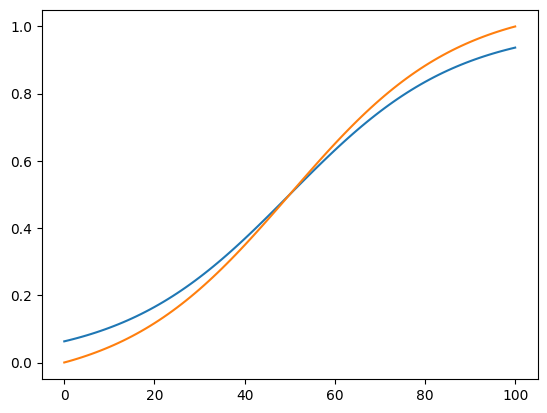

In [155]:
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

p0 = pred[:, 0]
p0 = np.array([i/100 for i in range(101)])
p0 = sigmoid((p0-0.5)*5.4)
plt.plot(p0)

p0 = (p0 - min(p0))/(max(p0)-min(p0))
p0 = np.clip(p0, 0.0001, 0.9999)
plt.plot(p0)

```
0.15246577482271312 -rf -knn -nn -tab (boostingのみ)
0.16141317621791187 -rf -knn -nn (boosting + tab)
0.14603296764550358 -rf -knn -tab (boosting + nn)
0.15962857016383242 -rf -nn -tab (boosting + knn)
0.19880100002949805 -rf -nn -knn -tab
0.1549086996071109 -rf
0.14709787098787236 -rf -knn
0.15552694031836586 -rf -xgb -cb
0.1676103909764996 -rf -lgb -cb


0.1486103472662918  a = 1, 0, 1.5, 0, 0.5
0.14573619761609635 a = 1, 0, 1, 0, 0.5
0.14555721433280364 a = 2, 0, 1, 0.2, 1.5
0.1446640534808395  a = 2, 0, 1, 0, 1 
0.14443877195214577 a = 2, 0, 1, 0.2, 1
0.1440592210659078  a = 2, 0, 1, 0.2, 0.8 
0.14362643242934164 a = 2, 0, 1, 0.2, 0.8 lgbm2を見直し
0.14405701359512002 ↑でKFoldの分割をgreeks.alphaにしたバージョン  !! nnがリークしている !!
0.13302360008161757 a = [2.1, 0.0, 4.0, 0.0, 0.0] ★★Currently Best CV <- !! nnがリークしている !!

nnを再学習(greeks.alphaでfoldに分割)
0.14495478908894055 a = [3.3, 0.0, 0.0, 0.5, 0.7]
0.14516239372852643 a = [3.9, 0.0, 0.0, 0.9, 0.5]
0.13448841870323322 a = [3.9, 0.0, 0.0, 0.9, 0.5] lightGBMの再学習（optunaで探索時にcalc_new_predをするようにした）LV1.6
0.1320047117991178  a = [3.9, 0.0, 0.0, 0.9, 0.5] positive_weight = 2.0  LB1.7
0.12654137375083563 -> predを補正（１）


InvalidParameterError: The 'metric' parameter of KNeighborsClassifier must be a str among {'sokalsneath', 'minkowski', 'wminkowski', 'yule', 'jaccard', 'chebyshev', 'seuclidean', 'hamming', 'cosine', 'cityblock', 'rogerstanimoto', 'kulsinski', 'dice', 'correlation', 'sqeuclidean', 'l1', 'precomputed', 'mahalanobis', 'sokalmichener', 'p', 'haversine', 'euclidean', 'nan_euclidean', 'pyfunc', 'manhattan', 'infinity', 'matching', 'russellrao', 'l2', 'braycurtis', 'canberra'} or a callable. Got 'xxx' instead.
```

In [156]:
# print("lgbm2..")



# def obj_lgbm(trial):
#     params = {
#         'boosting_type':'gbdt',
#         'class_weight':'balanced',
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 100, step=0.1),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 100, step=0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 64, step=1),
#         'min_child_samples': trial.suggest_int('min_child_samples', 8, 64, step=1),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
#         'subsample_freq': trial.suggest_int('subsample_freq', 0, 3, step=1),
#     }
    
#     lgb2 = LGBMClassifier(**params)
#     lgb2.fit(X_train2, y_train, sample_weight=weights)
#     y_lgb2 = lgb2.predict_proba(X_valid2)
#     lgb2_loss = balanced_log_loss(y_valid, y_lgb2[:, 1])
#     return lgb2_loss
        

# study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))#direction='minimize')
# study.enqueue_trial(lgbm_params2)
# study.optimize(obj_lgbm, n_trials=100)

# lgbm_params2 = dict(study.best_trial.params.items())
# lgbm_params2

In [157]:
y_len

[124, 124, 123, 123, 123]

### スタッキング（２段目）

2段目は、各FOLDのvalidデータを用いて学習させる。こうしないとリークする可能性がありそうなので。

In [158]:
# Optuna

def obj_lgbm2(trial):
    params = {
        'boosting_type':'gbdt',
        'class_weight':'balanced',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 100, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 100, step=0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 64, step=1),
        'min_child_samples': trial.suggest_int('min_child_samples', 8, 64, step=1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 3, step=1),
    }
    
    lgb_2 = LGBMClassifier(**params)

    
    score = 0
    start = 0
    for idx, size in enumerate(y_len):
        valid_idx = [False for _ in range(len(y_preds))]
        for i in range(start, start+size):
            valid_idx[i] = True
        train_idx = list(map(lambda x: not x, valid_idx))
        X_train, y_train = y_preds[train_idx], y_true[train_idx]
        X_valid, y_valid = y_preds[valid_idx], y_true[valid_idx]
        lgb_2.fit(X_train, y_train)
        pred2 = lgb_2.predict_proba(X_valid)
        s = balanced_log_loss(y_valid, pred2[:, 1])
#         print(f"fold{idx} = {s}")
        start += size
        score += s
    
    return score/5
      
    
lgbm_params_2 = {'n_estimators': 400,
 'reg_alpha': 6.2,
 'reg_lambda': 22.900000000000002,
 'num_leaves': 30,
 'min_child_samples': 45,
 'colsample_bytree': 0.5,
 'subsample': 0.8,
 'subsample_freq': 1}

# do_opt = True
if do_opt :
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))#direction='minimize')
    study.enqueue_trial(lgbm_params_2)
    study.optimize(obj_lgbm2, n_trials=200)

In [159]:
if do_opt :
    lgbm_params_2 = dict(study.best_trial.params.items())
lgbm_params_2

{'n_estimators': 400,
 'reg_alpha': 6.2,
 'reg_lambda': 22.900000000000002,
 'num_leaves': 30,
 'min_child_samples': 45,
 'colsample_bytree': 0.5,
 'subsample': 0.8,
 'subsample_freq': 1}

In [160]:
from sklearn.linear_model import LogisticRegression

if check_CV:

    lgb_2 = LGBMClassifier(boosting_type='gbdt', class_weight='balanced', **lgbm_params_2)
#     lgb_2 = LogisticRegression()
    
    score = 0
    start = 0
    for idx, size in enumerate(y_len):
        valid_idx = [False for _ in range(len(y_preds))]
        for i in range(start, start+size):
            valid_idx[i] = True
        train_idx = list(map(lambda x: not x, valid_idx))
        X_train, y_train = y_preds[train_idx], y_true[train_idx]
        X_valid, y_valid = y_preds[valid_idx], y_true[valid_idx]
        lgb_2.fit(X_train, y_train)
        pred2 = lgb_2.predict_proba(X_valid)
        s = balanced_log_loss(y_valid, pred2[:, 1])
        print(f"fold{idx} = {s}")
        start += size
        score += s
    
    print("5fold average = ", score/5)

fold0 = 0.17238593590827803
fold1 = 0.13296357563276173
fold2 = 0.3468068556512788
fold3 = 0.09978141292321988
fold4 = 0.12931183043707203
5fold average =  0.1762499221105221


In [161]:
lgb_2.fit(y_preds, y_true)
pred2 = lgb_2.predict_proba(y_preds)
print(balanced_log_loss(y_true, pred2[:, 1]))

0.1259750258574585


## fit models(final parameter)

なぜか、5foldで作成したモデルだと性能が下がる傾向があった。testデータにtrainデータが**リークしている可能性**がありそうな気もするが、とりあえず、各予測器をパラメータを決めたあと、train全体で作成しなおし。

In [181]:
X = df_train[df_train.columns[:-1]]
y = df_train.Class

In [182]:
use_best_fold = True

In [183]:
if use_best_fold :
    lgb = best_model['lgb'][1]
else:
    lgb.fit(X[lgb_selected], y, sample_weight=classes_weights)
#     lgb.fit(X[lgb_selected], y)
    
y_lgb = lgb.predict_proba(X[lgb_selected])
balanced_log_loss(y, y_lgb[:, 1])

0.01697028419253346

In [184]:
# pd.DataFrame(lgb.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)

In [185]:
if use_best_fold:
    lgb2 = best_model['lgb2'][1]
else:
    lgb2.fit(X, y, sample_weight=classes_weights2)
y_lgb2 = lgb2.predict_proba(X)
balanced_log_loss(y, y_lgb2[:, 1])

0.013655259879186378

In [186]:
if use_best_fold:
    xgb = best_model['xgb'][1]
else: 
    xgb.fit(X[lgb_selected], y, sample_weight=classes_weights)
y_xgb = xgb.predict_proba(X[lgb_selected])
balanced_log_loss(y, y_xgb[:, 1])

0.03114901271183487

In [187]:
if use_best_fold:
    xgb2 = best_model['xgb2'][1]
else:
    xgb2.fit(X, y, sample_weight=classes_weights2)
y_xgb2 = xgb2.predict_proba(X)
balanced_log_loss(y, y_xgb2[:, 1])

0.025022961348856856

In [188]:
if use_best_fold:
    cb = best_model['cb'][1]
else:
    cb.fit(X[lgb_selected], y, logging_level="Silent", sample_weight=classes_weights)
#     cb.fit(X[lgb_selected], y, logging_level="Silent")
y_cb = cb.predict_proba(X[lgb_selected])
balanced_log_loss(y, y_cb[:, 1])

0.0248620425809194

In [189]:
if use_best_fold:
    cb2 =  best_model['cb2'][1]
else:
    cb2.fit(X, y, logging_level="Silent", sample_weight=classes_weights2)
y_cb2 = cb2.predict_proba(X)
balanced_log_loss(y, y_cb2[:, 1])

0.028192932577094584

In [190]:
if use_best_fold:
    rf = best_model['rf'][1]
else:
    rf.fit(X, y, sample_weight=classes_weights)
y_rf = rf.predict_proba(X)
balanced_log_loss(y, y_rf[:, 1])

0.14071131734913855

In [191]:
XX = torch.Tensor(X[X.columns[:-1]].to_numpy()).to(device)
y_nn, features = nn_predict_proba(XX, nn_single_model)
features = features.detach().cpu().numpy()
balanced_log_loss(y, y_nn[:, 1])

0.06132052984798789

In [192]:
if use_best_fold:
    knn = best_model['knn'][1]
else:
    knn.fit(features, y)#, sample_weight=weights)
y_xxx = knn.predict_proba(features)
y_xxx = calc_new_pred(y_xxx)
balanced_log_loss(y, y_xxx[:, 1])

0.8431991958314883

In [195]:
XX = torch.Tensor(X[X.columns[:-1]].to_numpy()).to(device)
y_nn2, features = nn_predict_proba(XX, nn_single_model2)
features = features.detach().cpu().numpy()
balanced_log_loss(y, y_nn2[:, 1])

0.06310310866714847

In [196]:
if use_best_fold:
    knn2 = best_model['knn2'][1]
else:
    knn2.fit(features, y)#, sample_weight=weights)
y_xxx2 = knn2.predict_proba(features)
y_xxx2 = calc_new_pred(y_xxx2)
balanced_log_loss(y, y_xxx2[:, 1])

0.5857843448967294

In [197]:
# tabpfnには正則化する前のデータを入力する
X = df_train_noscale[df_train.columns[:-1]]
y = df_train_noscale.Class

In [198]:
if use_best_fold:
    tab = best_model['tab'][1]
else:
    tab.fit(X[lgb_selected], y)
y_tab = tab.predict_proba(X[lgb_selected])
y_tab = calc_new_pred(y_tab) # <- ここに入れるのは良いかも
balanced_log_loss(y, y_tab[:, 1])

0.0781616000013481

In [199]:
if use_best_fold:
    tab2 = best_model['tab2'][1]
else:
    tab2.fit(X, y)
y_tab2 = tab2.predict_proba(X)
y_tab2 = calc_new_pred(y_tab2) # <- ここに入れるのは良いかも
balanced_log_loss(y, y_tab2[:, 1])

0.06961384396953718

In [200]:
pred = ((y_lgb + y_lgb2)/2*a[0] +
        (y_xgb + y_xgb2)/2*a[1] +
        (y_cb + y_cb2)/2*a[2] + 
        y_rf * a[3] + 
        (y_nn + y_nn2) * a[4] +
        (y_xxx + y_xxx2)/2*a[5] + 
        (y_tab + y_tab2)/2*a[6]
       )/sum(a)

balanced_log_loss(y,pred[:, 1])

0.04734593937221607

In [201]:
pred = calc_new_pred(pred)
balanced_log_loss(y, pred[:, 1])

0.10738135588508348

In [202]:
y_preds = np.concatenate([(y_lgb + y_lgb2)/2,(y_xgb + y_xgb2)/2, (y_cb + y_cb2)/2, y_rf, y_nn,  
                          (y_xxx + y_xxx)/2, (y_tab + y_tab2)/2], axis=1)
pred2 = lgb_2.predict_proba(y_preds)
balanced_log_loss(y, pred2[:, 1])

0.060164389014836554

In [203]:
pred2 = calc_new_pred(pred2)
balanced_log_loss(y, pred2[:, 1])

0.10010946011268311

In [219]:
# result = pd.DataFrame(y_lgb[:,1], columns=['lgb'])
# result['lgb2'] = y_lgb2[:, 1]
# result['xgb'] = y_xgb[:, 1]
# result['xgb2'] = y_xgb2[:, 1]
# result['cb'] = y_cb[:, 1]
# result['cb2'] = y_cb2[:, 1]
# result['rf'] = y_rf[:, 1]
# result['nn'] = y_nn[:, 1]
# result['knn'] = y_xxx[:, 1]
# result['knn2'] = y_xxx2[:, 1]
# result['tab'] = y_tab[:, 1]
# result['tab2'] = y_tab2[:, 1]
# sns.heatmap(result.corr(), vmax=1, vmin=0.9, center=0.95)
# result.corr()

,lgb,xgb,cb,rf,nn,nn2,knn,knn2,tab
lgb,1.000000,0.994175,0.993564,0.935961,0.938580,0.958084,0.139443,0.320183,0.956863
xgb,0.994175,1.000000,0.992266,0.953369,0.944585,0.958299,0.120398,0.322425,0.963113
cb,0.993564,0.992266,1.000000,0.937811,0.937383,0.957167,0.139331,0.319452,0.951651
rf,0.935961,0.953369,0.937811,1.000000,0.929161,0.923742,0.019058,0.288223,0.940691
nn,0.938580,0.944585,0.937383,0.929161,1.000000,0.975287,0.119392,0.338757,0.940966
nn2,0.958084,0.958299,0.957167,0.923742,0.975287,1.000000,0.127948,0.315012,0.945721
knn,0.139443,0.120398,0.139331,0.019058,0.119392,0.127948,1.000000,0.354065,0.091596
knn2,0.320183,0.322425,0.319452,0.288223,0.338757,0.315012,0.354065,1.000000,0.322433
tab,0.956863,0.963113,0.951651,0.940691,0.940966,0.945721,0.091596,0.322433,1.000000


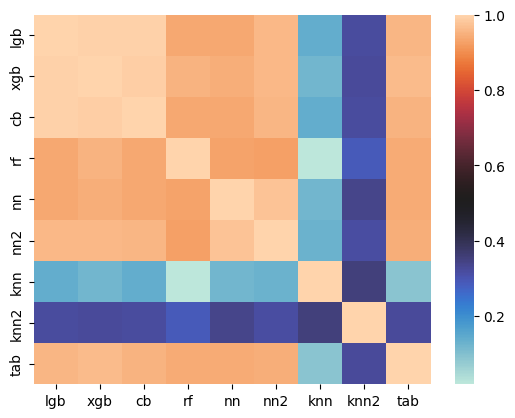

In [205]:
result = pd.DataFrame((y_lgb[:,1]+y_lgb2[:, 1])/2, columns=['lgb'])
result['xgb'] = (y_xgb[:, 1] + y_xgb2[:, 1])/2
result['cb'] = (y_cb[:, 1] + y_cb2[:, 1])/2
result['rf'] = y_rf[:, 1]
result['nn'] = y_nn[:, 1]
result['nn2'] = y_nn2[:, 1]
result['knn'] = y_xxx[:, 1]
result['knn2'] = y_xxx2[:, 1]
result['tab'] = (y_tab[:, 1] + y_tab2[:, 1])/2

corr = result.corr()
ma, mi = corr.max().max(), corr.min().min()
sns.heatmap(corr, vmax=ma, vmin=mi, center=(mi+ma)/2)
corr

# infer

In [206]:
pred_lgb = lgb.predict_proba(df_test[lgb_selected])
pred_xgb = xgb.predict_proba(df_test[lgb_selected])
pred_cb = cb.predict_proba(df_test[lgb_selected])

pred_lgb2 = lgb2.predict_proba(df_test)
pred_xgb2 = xgb2.predict_proba(df_test)
pred_cb2 = cb2.predict_proba(df_test)

pred_rf = rf.predict_proba(df_test)

XX = torch.Tensor(df_test[df_test.columns[:-1]].to_numpy()).to(device)
pred_nn, pred_features = nn_predict_proba(XX, nn_single_model)
pred_features = pred_features.detach().cpu().numpy()

pred_nn2, pred_features2 = nn_predict_proba(XX, nn_single_model)
pred_features2 = pred_features2.detach().cpu().numpy()

pred_xxx = knn.predict_proba(pred_features)
pred_xxx = calc_new_pred(pred_xxx)
pred_xxx2 = knn2.predict_proba(pred_features2)
pred_xxx2 = calc_new_pred(pred_xxx2)

pred_tab = tab.predict_proba(df_test_noscale[lgb_selected])
pred_tab = calc_new_pred(pred_tab)
pred_tab2 = tab2.predict_proba(df_test_noscale)
pred_tab2 = calc_new_pred(pred_tab2)


# 　全モデルが同じ選択の場合は、正解とする(y_rf除く)ーーーーーーーーーー
th_c0 = 0.75
sel0 = (pred_lgb > th_c0)&(pred_lgb2 > th_c0)&(pred_xgb > th_c0)&(pred_xgb2 > th_c0)&(pred_cb > th_c0)&(pred_cb2 > th_c0)&\
        (pred_nn > th_c0)&(pred_nn2 > th_c0)&(pred_xxx > th_c0)&(pred_xxx2 > th_c0)&(pred_tab > th_c0)&(pred_tab2 > th_c0)
th_c1 = 0.95
sel1 = (pred_lgb > th_c1)&(pred_lgb2 > th_c1)&(pred_xgb > th_c1)&(pred_xgb2 > th_c1)&(pred_cb > th_c1)&(pred_cb2 > th_c1)&\
        (pred_nn > th_c1)&(pred_nn2 > th_c1)&(pred_xxx > th_c1)&(pred_xxx2 > th_c1)&(pred_tab > th_c1)&(pred_tab2 > th_c1)
#ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー


pred_lgb = (pred_lgb + pred_lgb2)/2
pred_xgb = (pred_xgb + pred_xgb2)/2
pred_cb = (pred_cb + pred_cb2)/2
pred_nn = (pred_nn + pred_nn2)/2
pred_xxx = (pred_xxx+pred_xxx)/2
pred_tab = (pred_tab + pred_tab2)/2

pred = (
    pred_lgb * a[0] + 
    pred_xgb * a[1] + 
    pred_cb  * a[2] + 
    pred_rf  * a[3] + 
    pred_nn  * a[4] + 
    pred_xxx * a[5] + 
    pred_tab * a[6] ) /sum(a)

# print(pred)
    
p0 = pred[:, 0]
p0 = sigmoid((p0-0.5)*5.4)
p0 = (p0 - min(p0))/(max(p0)-min(p0)+1e-15)

p0[p0 > 0.99] = 1
p0[p0 < 0.01] = 0

# 　全モデルが同じ選択の場合は、正解とする(y_rf除く)ーーーーーーーーーー
p0[sel0[:, 0]] = 1
p0[sel1[:, 1]] = 0
#ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー

pred[:,1] = 1-p0
pred[:,0] = p0      

if use_new_pred:
    pred = calc_new_pred(pred)

pred

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [222]:
submission = pd.read_csv('../input/icr-identify-age-related-conditions/sample_submission.csv')
submission['class_0'] = pred[:,0]
submission['class_1'] = pred[:,1]

In [223]:
modify = {
    1:0,
    2:0,
    6:0,
    9:0,
    10:0,
    12:0,
    14:1,
}

for idx in modify:
    val = modify[idx]
    if len(submission) < idx :
        break
    if val == 0:
        submission.iloc[idx, 1] = 1
        submission.iloc[idx, 2] = 0
    else:
        submission.iloc[idx, 1] = 0
        submission.iloc[idx, 2] = 1

In [224]:
submission.to_csv('submission.csv', index=False)
submission

,Id,class_0,class_1
0,00eed32682bb,0.0,1.0
1,010ebe33f668,1.0,0.0
2,02fa521e1838,1.0,0.0
3,040e15f562a2,0.0,1.0
4,046e85c7cc7f,0.0,1.0


### 間違った場合のペナルティをチェック

In [ ]:
# from sklearn.metrics import log_loss
# def balanced_log_loss(y_true, y_pred):
#     nc = np.bincount(y_true)
#     return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

In [109]:
# one =   26
# zero =  130
# print(one, zero)
# y = np.array([1 for _ in range(one)] + [0 for _ in range(zero)])
# x = np.array([0 for _ in range(one+zero)])
# x[-1] = 1
# print(balanced_log_loss(y, x))

In [110]:
# # one = sum(train_df.Class == 1)
# # zero = sum(train_df.Class == 0)
# # print(one, zero, one/(one+zero))
# one = 26#int(1000*one/(one+zero))
# zero = 130
# print(one, zero)
# y = np.array([1 for _ in range(one)] + [0 for _ in range(zero)])
# for i in range(one+zero+1):
#     x = np.array([1 for _ in range(i)] + [0 for _ in range(one+zero-i)])
#     print(f"{one+zero-i}:{i} -->",  balanced_log_loss(y, x))

In [111]:
# one = sum(train_df.Class == 1)
# zero = sum(train_df.Class == 0)
# y = np.array([1 for _ in range(one)] + [0 for _ in range(zero)])
# for i in range(zero):
#     x = np.array([1 for _ in range(one+i)] + [0 for _ in range(zero-i)])
#     print(round(sum(x==0)/zero, 3), "-->",  balanced_log_loss(y, x))